# **Simultaneous Prediction of Yield Strength, Ultimate Tensile Strength, and Elongation Incorporating Elemental Descriptors using DNN-Multioutput Regressor**

### *With Process Condition + Elemental Descriptors*

In [313]:
### import relevant libraries  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr
from sklearn.inspection import permutation_importance
from sklearn.ensemble import IsolationForest
import tensorflow as tf 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
from keras.metrics import R2Score, RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adamax
from scikeras.wrappers import KerasRegressor
import time 

import warnings
warnings.filterwarnings('ignore') 

In [314]:
from sklearn.model_selection import cross_validate

## **(1) Data Loading**

In [315]:
# set the file path
fpath = 'compList_with_descriptors_30May2024.csv'

# loading the data
hea_ed_df = pd.read_csv(fpath)

# make a copy of the data file
hea_ed_df_copy = hea_ed_df.copy()

# display the first few rows data
hea_ed_df_copy.head()

Unnamed: 0    C   Al     V    Cr    Mn    Fe    Co    Ni   Cu  ...  \
0           0  0.0  0.0  10.0  15.0   0.0  40.0  10.0  25.0  0.0  ...   
1           1  0.0  0.0  10.0  15.0   5.0  35.0  10.0  25.0  0.0  ...   
2           2  0.0  0.0  10.0  15.0  10.0  30.0  10.0  25.0  0.0  ...   
3           3  0.0  0.0  20.0  15.0   0.0  20.0   0.0  45.0  0.0  ...   
4           4  0.0  0.0  20.0  15.0   0.0  20.0   0.0  45.0  0.0  ...   

   mean thermal_conductivity  std_dev thermal_conductivity  \
0                      81.95                     21.379229   
1                      78.34                     27.859490   
2                      74.73                     32.374792   
3                      77.25                     28.296668   
4                      77.25                     28.296668   

   mean melting_point  std_dev melting_point  mean bulk_modulus  \
0              1878.5             207.392132              171.0   
1              1863.9             221.079083              168.5   
2              1849.3             233.187403              166.0   
3              1903.4             247.761895              171.0   
4              1903.4             247.761895              171.0   

   std_dev bulk_modulus  mean coefficient_of_linear_thermal_expansion  \
0              8.959470                                      0.000011   
1             15.405767                                      0.000011   
2             19.230479                                      0.000012   
3             10.661570                                      0.000011   
4             10.661570                                      0.000011   

   std_dev coefficient_of_linear_thermal_expansion  constraint_1  constraint_2  
0                                         0.000003    145.500000     24.250000  
1                                         0.000004    145.500000     24.250000  
2                                         0.000005    145.500000     24.250000  
3                                         0.000004    162.166667     27.027778  
4                                         0.000004    153.833333     25.638889  

[5 rows x 58 columns]

In [316]:
# display the data info
hea_ed_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 58 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Unnamed: 0                                       569 non-null    int64  
 1   C                                                569 non-null    float64
 2   Al                                               569 non-null    float64
 3   V                                                569 non-null    float64
 4   Cr                                               569 non-null    float64
 5   Mn                                               569 non-null    float64
 6   Fe                                               569 non-null    float64
 7   Co                                               569 non-null    float64
 8   Ni                                               569 non-null    float64
 9   Cu                              

## **(2) Data Preprocessing**

### **(A) Drop Irrelevant Columns**

In [317]:
# drop irrelevant columns
hea_ed_df_copy = hea_ed_df_copy.drop(['Unnamed: 0', 'C', 'Al', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Mo', 'Ti', 'B', 'constraint_2'],axis = 1)
# display the new dataframe
hea_ed_df_copy.head()

Hom_Temp(K)  CR(%)  Anneal_Temp(K)  Anneal_Time(h)  YS(Mpa)  UTS(Mpa)  \
0         1373    0.0            1173        0.166667    397.0     721.0   
1         1373    0.0            1173        0.166667    442.0     745.0   
2         1373    0.0            1173        0.166667    544.0     860.0   
3         1373   75.0            1273        0.166667    352.0     790.0   
4         1373   75.0            1223        0.166667    555.0     976.0   

   El(%)   Density  Miedema_dH_inter  Miedema_dH_amor  ...  \
0   58.0  7.895604         -0.231716        -0.139821  ...   
1   53.0  7.874702         -0.253863        -0.160520  ...   
2   46.2  7.853876         -0.271625        -0.175872  ...   
3   64.2  7.791467         -0.258342        -0.162614  ...   
4   45.6  7.791467         -0.258342        -0.162614  ...   

   std_dev electrical_resistivity  mean thermal_conductivity  \
0                    4.450862e-08                      81.95   
1                    3.348548e-07                      78.34   
2                    4.517508e-07                      74.73   
3                    5.791395e-08                      77.25   
4                    5.791395e-08                      77.25   

   std_dev thermal_conductivity  mean melting_point  std_dev melting_point  \
0                     21.379229              1878.5             207.392132   
1                     27.859490              1863.9             221.079083   
2                     32.374792              1849.3             233.187403   
3                     28.296668              1903.4             247.761895   
4                     28.296668              1903.4             247.761895   

   mean bulk_modulus  std_dev bulk_modulus  \
0              171.0              8.959470   
1              168.5             15.405767   
2              166.0             19.230479   
3              171.0             10.661570   
4              171.0             10.661570   

   mean coefficient_of_linear_thermal_expansion  \
0                                      0.000011   
1                                      0.000011   
2                                      0.000012   
3                                      0.000011   
4                                      0.000011   

   std_dev coefficient_of_linear_thermal_expansion  constraint_1  
0                                         0.000003    145.500000  
1                                         0.000004    145.500000  
2                                         0.000005    145.500000  
3                                         0.000004    162.166667  
4                                         0.000004    153.833333  

[5 rows x 44 columns]

### **(B) Investigate Missing Values**

In [318]:
# check for missing values 
hea_ed_df_copy.isnull().sum()

Hom_Temp(K)                                        0
CR(%)                                              0
Anneal_Temp(K)                                     0
Anneal_Time(h)                                     0
YS(Mpa)                                            0
UTS(Mpa)                                           0
El(%)                                              0
Density                                            0
Miedema_dH_inter                                   0
Miedema_dH_amor                                    0
Miedema_dH_ss_min                                  0
Yang delta                                         0
Yang omega                                         0
APE mean                                           0
Radii local mismatch                               0
Radii gamma                                        0
Configuration entropy                              0
Lambda entropy                                     0
Electronegativity delta                       

### **(C) Renaming Columns**

In [319]:
# rename columns
hea_ed_df_copy.rename(columns ={
                             'Hom_Temp(K)': 'homo_temp',
                             'CR(%)': 'cold_rolling',
                             'Anneal_Temp(K)': 'anneal_temp',
                             'Anneal_Time(h)': 'anneal_time',
                             'Density': 'density', 
                             'Miedema_dH_inter': 'deltaH_inter',
                             'Miedema_dH_amor': 'deltaH_amor', 
                             'Miedema_dH_ss_min': 'deltaH_ss_min', 
                             'Yang delta': 'yang_delta', 
                             'Yang omega': 'yang_omega', 
                             'APE mean': 'mean_APE', 
                             'Radii local mismatch ': 'radii_local_mismatch', 
                             'Radii gamma': 'radii_gamma', 
                             'Configuration entropy': 'config_entropy', 
                             'Total weight ': 'total_weight', 
                             'Lambda entropy': 'lambda_entropy', 
                             'Electronegativity delta': 'electronegativity_delta', 
                             'Electronegativity local mismatch': 'electronegativity_local_mismatch', 
                             'VEC mean': 'mean_VEC', 
                             'Mixing enthalpy': 'mixing_enthalpy', 
                             'Mean cohesive energy': 'mean_cohesive_energy', 
                             'Shear modulus mean': 'shear_modulus_mean', 
                             'Shear modulus delta': 'shear_modulus_delta', 
                             'Shear modulus local mismatch': 'shear_modulus_local_mismatch', 
                             'Shear modulus strength model ': 'shear_modulus_strength_model',
                             'mean atomic_mass': 'mean_atomic_mass', 
                             'std_dev atomic_mass': 'std_dev_atomic_mass',
                             'mean atomic_radius': 'mean_atomic_radius',
                             'std_dev atomic_radius': 'std_dev_atomic_radius',  
                             'mean mendeleev_no': 'mean_mendeleev_no', 
                             'std_dev mendeleev_no': 'std_dev_mendeleev_no',
                             'mean electrical_resistivity': 'mean_electrical_resistivity', 
                             'std_dev electrical_resistivity': 'std_dev_electrical_resistivity', 
                             'mean thermal_conductivity': 'mean_thermal_conductivity', 
                             'std_dev thermal_conductivity': 'std_dev_thermal_conductivity', 
                             'mean melting_point': 'mean_melting_point', 
                             'std_dev melting_point': 'std_dev_melting_point', 
                             'mean bulk_modulus': 'mean_bulk_modulus', 
                             'std_dev bulk_modulus': 'std_dev_bulok_modulus', 
                             'mean coefficient_of_linear_thermal_expansion': 'mean_coef_linear_thermal_expansion', 
                             'std_dev coefficient_of_linear_thermal_expansion': 'std_dev_coef_linear_thermal_expansion', 
                             'Gibbs (BCC-FCC)': 'gibbs_bcc_fcc', 
                             'Specific heat': 'specific_heat',
                             'Liquidus': 'liquidus', 
                             'Solidus': 'solidus', 
                             'YS(Mpa)': 'yield_strength', 
                             'UTS(Mpa)': 'ultimate_tensile_strength',
                             'El(%)': 'elongation',
                             }, inplace = True)
# display the dataframe with new column names
hea_ed_df_copy.head()

homo_temp  cold_rolling  anneal_temp  anneal_time  yield_strength  \
0       1373           0.0         1173     0.166667           397.0   
1       1373           0.0         1173     0.166667           442.0   
2       1373           0.0         1173     0.166667           544.0   
3       1373          75.0         1273     0.166667           352.0   
4       1373          75.0         1223     0.166667           555.0   

   ultimate_tensile_strength  elongation   density  deltaH_inter  deltaH_amor  \
0                      721.0        58.0  7.895604     -0.231716    -0.139821   
1                      745.0        53.0  7.874702     -0.253863    -0.160520   
2                      860.0        46.2  7.853876     -0.271625    -0.175872   
3                      790.0        64.2  7.791467     -0.258342    -0.162614   
4                      976.0        45.6  7.791467     -0.258342    -0.162614   

   ...  std_dev_electrical_resistivity  mean_thermal_conductivity  \
0  ...                    4.450862e-08                      81.95   
1  ...                    3.348548e-07                      78.34   
2  ...                    4.517508e-07                      74.73   
3  ...                    5.791395e-08                      77.25   
4  ...                    5.791395e-08                      77.25   

   std_dev_thermal_conductivity  mean_melting_point  std_dev_melting_point  \
0                     21.379229              1878.5             207.392132   
1                     27.859490              1863.9             221.079083   
2                     32.374792              1849.3             233.187403   
3                     28.296668              1903.4             247.761895   
4                     28.296668              1903.4             247.761895   

   mean_bulk_modulus  std_dev_bulok_modulus  \
0              171.0               8.959470   
1              168.5              15.405767   
2              166.0              19.230479   
3              171.0              10.661570   
4              171.0              10.661570   

   mean_coef_linear_thermal_expansion  std_dev_coef_linear_thermal_expansion  \
0                            0.000011                               0.000003   
1                            0.000011                               0.000004   
2                            0.000012                               0.000005   
3                            0.000011                               0.000004   
4                            0.000011                               0.000004   

   constraint_1  
0    145.500000  
1    145.500000  
2    145.500000  
3    162.166667  
4    153.833333  

[5 rows x 44 columns]

### **(D) Count the Number of Duplicate Rows**

In [320]:
# count the number of duplicate rows 
hea_ed_df_copy.duplicated().sum()

0

### **(E) Correlation Test for Elemental Descriptors with Mechanical Properties**

In [321]:
# drop columns related to processing conditions and store it into a new variable for elemental descriptors
x_ed = hea_ed_df_copy.drop(['yield_strength', 
                            'ultimate_tensile_strength', 
                            'elongation', 
                            'homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time', 'constraint_1'], axis = 1)
# extract columns related to processing conditions and store it into a new variable
x_not_ed = hea_ed_df_copy[['homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time','constraint_1']]
# extract columns related to target variables and store it into a new variable 
y = hea_ed_df_copy[['yield_strength', 'ultimate_tensile_strength', 'elongation']]

In [322]:
# define a function to get significant features based on Spearman correlation p-values
def get_significant_features(x, y, significance_level):
    # extract feature names 
    feature_names = x.columns
    # define empty list to store significant features and p-values  
    significant_features = []
    p_val_ys = []
    p_val_uts = []
    p_val_el = []


    # loop through each feature 
    for name in feature_names:
        # calculate the Spearman correlation and p-value with yield strength target variable 
        corr1, p_val1 = spearmanr(x[name], y['yield_strength'])
        # calculate the Spearman correlation and p-value with ultimate tensile strength target variable 
        corr2, p_val2 = spearmanr(x[name], y['ultimate_tensile_strength'])
        # calculate the Spearman correlation and p-value with elongation target variable 
        corr3, p_val3 = spearmanr(x[name], y['elongation'])
        
        # check all p-values are less than or equal to the significance level 
        if p_val1 <= significance_level and p_val2 <= significance_level and p_val3 <= significance_level:
            # if so, consider the feature significant and add it to the list and the p-values
            significant_features.append(name)
            p_val_ys.append(p_val1)
            p_val_uts.append(p_val2)
            p_val_el.append(p_val3)
        overall_significant_features = pd.DataFrame({"significant_features": significant_features, 
                                                     "p-value (YS)": p_val_ys, 
                                                     "p-value (UTS)": p_val_uts, 
                                                     "p-value (EL)": p_val_el})
    return overall_significant_features

# call the function to get significant features 
significantFeatures = get_significant_features(x_ed, y, 0.1)
# display the significant feature names 
significantFeatures

significant_features  p-value (YS)  p-value (UTS)  \
0                        deltaH_ss_min  3.627014e-04   2.026764e-04   
1                           yang_delta  6.280654e-04   9.142199e-05   
2                           yang_omega  6.728885e-04   5.533649e-06   
3                 Radii local mismatch  2.808766e-04   3.144936e-04   
4                          radii_gamma  4.633767e-02   5.649267e-02   
5                       lambda_entropy  2.765629e-03   2.270585e-04   
6                      mixing_enthalpy  1.139413e-05   3.173295e-07   
7                 mean_cohesive_energy  2.499590e-04   7.407353e-09   
8                   shear_modulus_mean  2.612888e-02   2.481845e-04   
9                  shear_modulus_delta  8.383964e-09   3.522741e-09   
10        shear_modulus_local_mismatch  1.415289e-12   3.241322e-13   
11        Shear modulus strength model  1.317759e-09   9.734565e-10   
12                 std_dev_atomic_mass  2.962282e-11   8.731977e-16   
13                  mean_atomic_radius  6.337249e-06   7.106851e-08   
14               std_dev_atomic_radius  1.169817e-04   1.220897e-06   
15                   mean_mendeleev_no  7.630512e-03   3.232058e-02   
16                std_dev_mendeleev_no  2.209310e-07   8.887338e-08   
17           mean_thermal_conductivity  2.930930e-07   1.560080e-07   
18                  mean_melting_point  5.620587e-04   4.919313e-08   
19               std_dev_melting_point  4.361927e-12   6.335302e-15   
20  mean_coef_linear_thermal_expansion  3.453755e-05   1.303918e-09   

    p-value (EL)  
0   1.789746e-06  
1   4.501745e-05  
2   8.769394e-02  
3   8.928174e-10  
4   7.375255e-02  
5   5.144087e-04  
6   2.548260e-03  
7   4.794176e-03  
8   2.124662e-06  
9   4.099954e-09  
10  1.960834e-08  
11  6.252160e-10  
12  2.066158e-05  
13  2.653432e-03  
14  9.898154e-04  
15  3.434432e-08  
16  2.824610e-09  
17  2.021477e-05  
18  8.406982e-07  
19  6.336939e-07  
20  3.172723e-04

In [323]:
# create an empty DataFrame to store selected features 
feature_selected = pd.DataFrame()
# assign columns from x_not_ed (chemical composition + processing conditions) DataFrame as columns in feature_selected DataFrame 
feature_selected[x_not_ed.columns] = x_not_ed
# assign selected columns (i.e. correlated with target variables) from x_ed (elemental descriptors) DataFrame as columns in feature_selected DataFrame 
feature_selected[significantFeatures['significant_features']] = x_ed[significantFeatures['significant_features']]
# assign feature_selected DataFrame to hea_ed_df_copy DataFrame
hea_ed_df_copy = feature_selected
# display the updated DataFrame
hea_ed_df_copy

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
0         1373           0.0         1173     0.166667    145.500000   
1         1373           0.0         1173     0.166667    145.500000   
2         1373           0.0         1173     0.166667    145.500000   
3         1373          75.0         1273     0.166667    162.166667   
4         1373          75.0         1223     0.166667    153.833333   
..         ...           ...          ...          ...           ...   
564       1373          90.0          888     1.000000    588.000000   
565       1373          90.0          973     1.000000    673.000000   
566          0           0.0            0     0.000000     -0.000000   
567          0           0.0            0     0.000000     -0.000000   
568          0           0.0            0     0.000000     -0.000000   

     deltaH_ss_min  yang_delta  yang_omega  Radii local mismatch  radii_gamma  \
0        -0.271516    0.022961    3.739500              1.360000     1.043159   
1        -0.282731    0.024206    3.982747              1.522500     1.043117   
2        -0.286855    0.025078    4.024562              1.650000     1.043074   
3        -0.257647    0.026378    1.927837              1.710000     1.043026   
4        -0.257647    0.026378    1.927837              1.710000     1.043026   
..             ...         ...         ...                   ...          ...   
564      -0.211481    0.021771    6.737751              1.282500     1.033591   
565      -0.211481    0.021771    6.737751              1.282500     1.033591   
566      -0.143115    0.026202   16.682771              1.740366     1.042988   
567      -0.146120    0.026308   15.619671              1.750663     1.042985   
568      -0.151259    0.026517   13.865689              1.771044     1.042981   

     ...  Shear modulus strength model  std_dev_atomic_mass  \
0    ...                     -0.024079             3.216960   
1    ...                     -0.024250             3.150184   
2    ...                     -0.024404             3.106483   
3    ...                     -0.033158             3.906400   
4    ...                     -0.033158             3.906400   
..   ...                           ...                  ...   
564  ...                     -0.005133             2.219222   
565  ...                     -0.005133             2.219222   
566  ...                     -0.009267             2.007062   
567  ...                     -0.009921             2.039240   
568  ...                     -0.011207             2.100871   

     mean_atomic_radius  std_dev_atomic_radius  mean_mendeleev_no  \
0              1.377500               0.029014          61.500000   
1              1.377500               0.028347          61.450000   
2              1.377500               0.027898          61.400000   
3              1.367500               0.028607          61.700000   
4              1.367500               0.028607          61.700000   
..                  ...                    ...                ...   
564            1.381000               0.028121          62.320000   
565            1.381000               0.028121          62.320000   
566            1.394737               0.018827          60.468672   
567            1.394472               0.019177          60.437186   
568            1.393939               0.019838          60.373737   

     std_dev_mendeleev_no  mean_thermal_conductivity  mean_melting_point  \
0                4.802210                  81.950000         1878.500000   
1                4.705275                  78.340000         1863.900000   
2                4.643248                  74.730000         1849.300000   
3                6.337056                  77.250000         1903.400000   
4                6.337056                  77.250000         1903.400000   
..                    ...                        ...                 ...   
564              3.235643                  72.872

In [324]:
features_names = hea_ed_df_copy.select_dtypes(include = ['float64', 'int64']).columns
features_names

Index(['homo_temp', 'cold_rolling', 'anneal_temp', 'anneal_time',
       'constraint_1', 'deltaH_ss_min', 'yang_delta', 'yang_omega',
       'Radii local mismatch', 'radii_gamma', 'lambda_entropy',
       'mixing_enthalpy', 'mean_cohesive_energy', 'shear_modulus_mean',
       'shear_modulus_delta', 'shear_modulus_local_mismatch',
       'Shear modulus strength model', 'std_dev_atomic_mass',
       'mean_atomic_radius', 'std_dev_atomic_radius', 'mean_mendeleev_no',
       'std_dev_mendeleev_no', 'mean_thermal_conductivity',
       'mean_melting_point', 'std_dev_melting_point',
       'mean_coef_linear_thermal_expansion'],
      dtype='object')

In [325]:
hea_ed_df_copy[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = y

### **(F) Anomalies Detection using Isolation Forest**

In [326]:
# define features to consider for anomalies detection

# create Isolation Forest model
model = IsolationForest(n_estimators = 60, random_state=42)

# fit the model to the data
model.fit(hea_ed_df_copy[features_names])

# get anomalies scores for each data point
anomalies_scores = model.decision_function(hea_ed_df_copy[features_names])

# make a copy to store the anomalies scores 
hea_ed_df_scores = hea_ed_df_copy.copy()

# store the scores into the dataframe 
hea_ed_df_scores['anomalies_scorers'] = anomalies_scores
hea_ed_df_scores

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
0         1373           0.0         1173     0.166667    145.500000   
1         1373           0.0         1173     0.166667    145.500000   
2         1373           0.0         1173     0.166667    145.500000   
3         1373          75.0         1273     0.166667    162.166667   
4         1373          75.0         1223     0.166667    153.833333   
..         ...           ...          ...          ...           ...   
564       1373          90.0          888     1.000000    588.000000   
565       1373          90.0          973     1.000000    673.000000   
566          0           0.0            0     0.000000     -0.000000   
567          0           0.0            0     0.000000     -0.000000   
568          0           0.0            0     0.000000     -0.000000   

     deltaH_ss_min  yang_delta  yang_omega  Radii local mismatch  radii_gamma  \
0        -0.271516    0.022961    3.739500              1.360000     1.043159   
1        -0.282731    0.024206    3.982747              1.522500     1.043117   
2        -0.286855    0.025078    4.024562              1.650000     1.043074   
3        -0.257647    0.026378    1.927837              1.710000     1.043026   
4        -0.257647    0.026378    1.927837              1.710000     1.043026   
..             ...         ...         ...                   ...          ...   
564      -0.211481    0.021771    6.737751              1.282500     1.033591   
565      -0.211481    0.021771    6.737751              1.282500     1.033591   
566      -0.143115    0.026202   16.682771              1.740366     1.042988   
567      -0.146120    0.026308   15.619671              1.750663     1.042985   
568      -0.151259    0.026517   13.865689              1.771044     1.042981   

     ...  mean_mendeleev_no  std_dev_mendeleev_no  mean_thermal_conductivity  \
0    ...          61.500000              4.802210                  81.950000   
1    ...          61.450000              4.705275                  78.340000   
2    ...          61.400000              4.643248                  74.730000   
3    ...          61.700000              6.337056                  77.250000   
4    ...          61.700000              6.337056                  77.250000   
..   ...                ...                   ...                        ...   
564  ...          62.320000              3.235643                  72.872000   
565  ...          62.320000              3.235643                  72.872000   
566  ...          60.468672              2.076985                  54.572431   
567  ...          60.437186              2.146599                  54.625126   
568  ...          60.373737              2.276499                  54.731313   

     mean_melting_point  std_dev_melting_point  \
0           1878.500000             207.392132   
1           1863.900000             221.079083   
2           1849.300000             233.187403   
3           1903.400000             247.761895   
4           1903.400000             247.761895   
..                  ...                    ...   
564         1750.030000             167.719465   
565         1750.030000             167.719465   
566         1729.917293             250.606934   
567         1733.050251             252.458619   
568         1739.363636             255.959322   

     mean_coef_linear_thermal_expansion  yield_strength  \
0                              0.000011           397.0   
1                              0.000011           442.0   
2                              0.000012           544.0   
3                              0.000011           352.0   
4                              0.000011           555.0   
..                                  ...             ...   
564                            0.000014           437.0   
565                            0.000014           325.0   
566                            0.000015           180.0   
567            

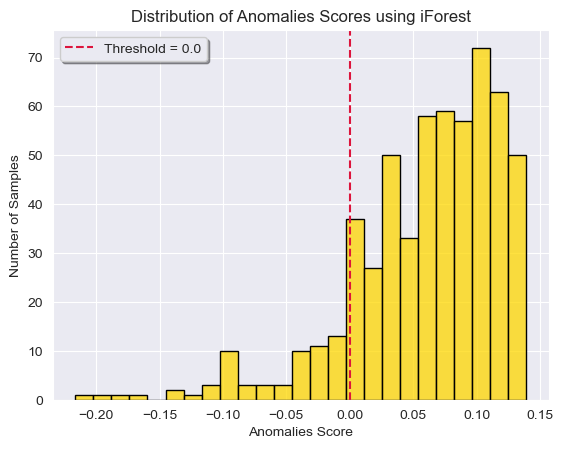

In [327]:
# distribution of anomalies detection
sns.set_style("darkgrid")
sns.histplot(data = hea_ed_df_scores['anomalies_scorers'], 
             color = 'gold',
             bins = 25, 
             edgecolor = "black")
plt.axvline(0, color = "crimson", linestyle = '--', label = "Threshold = {}".format(0.0))
plt.title("Distribution of Anomalies Scores using iForest")
plt.xlabel("Anomalies Score")
plt.ylabel("Number of Samples")
plt.legend(shadow = True)
plt.show()

In [328]:
# setting threshold to identify anomalies (adjust as needed)
threshold = 0.0

# identify and display the anomalies rows
hea_ed_df_scores[anomalies_scores < threshold]

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
23        1373          75.0         1173     0.166667         145.5   
30        1373          79.0         1173     1.000000         873.0   
35        1473          92.0         1173     1.000000         873.0   
39        1473          92.0         1173     1.000000         873.0   
40        1473          92.0         1073     1.000000         773.0   
..         ...           ...          ...          ...           ...   
551       1173          65.0          973     5.000000        3365.0   
552       1173          65.0         1073     5.000000        3865.0   
553       1173          65.0         1173     5.000000        4365.0   
554       1173          65.0         1273     5.000000        4865.0   
555       1173          65.0            0     0.000000          -0.0   

     deltaH_ss_min  yang_delta    yang_omega  Radii local mismatch  \
23       -0.094452    0.022163  9.868972e+00              1.350000   
30       -0.084090    0.059323  3.472499e+00              1.916575   
35       -0.107833    0.003761  1.211835e+01              0.222222   
39       -0.147732    0.003984  5.098660e+00              0.250000   
40       -0.007315    0.003984  1.007342e+07              0.250000   
..             ...         ...           ...                   ...   
551       0.012479    0.068239  8.728552e+00              2.562457   
552       0.012479    0.068239  8.728552e+00              2.562457   
553       0.012479    0.068239  8.728552e+00              2.562457   
554       0.012479    0.068239  8.728552e+00              2.562457   
555       0.012479    0.068239  8.728552e+00              2.562457   

     radii_gamma  ...  mean_mendeleev_no  std_dev_mendeleev_no  \
23      1.033504  ...          65.600000              5.160288   
30      1.394107  ...          62.155000              6.813738   
35      1.004823  ...          64.000000              3.000000   
39      1.004821  ...          64.000000              4.242641   
40      1.004821  ...          65.500000              2.121320   
..           ...  ...                ...                   ...   
551     1.349249  ...          65.809838              7.809172   
552     1.349249  ...          65.809838              7.809172   
553     1.349249  ...          65.809838              7.809172   
554     1.349249  ...          65.809838              7.809172   
555     1.349249  ...          65.809838              7.809172   

     mean_thermal_conductivity  mean_melting_point  std_dev_melting_point  \
23                  128.740000         1595.254000             181.489276   
30                   89.320000         1913.630000             436.513853   
35                   90.333333         1769.000000              41.509035   
39                   85.500000         1769.500000              58.689863   
40                   95.500000         1748.000000              28.284271   
..                         ...                 ...                    ...   
551                 144.573125         1663.224196             454.230100   
552                 144.573125         1663.224196             454.230100   
553                 144.573125         1663.224196             454.230100   
554                 144.573125         1663.224196             454.230100   
555                 144.573125         1663.224196             454.230100   

     mean_coef_linear_thermal_expansion  yield_strength  \
23                             0.000016           235.0   
30                             0.000011           617.0   
35                             0.000013           195.0   
39                             0.000013           180.0   
40                             0.000013           100.0   
..                                  ...             ...   
551                            0.000016          1018.0   
552                            0.000016           915.0   
553                            0.000016           

In [329]:
# filter non-anomalies rows based on scores
filtered_data = hea_ed_df_scores[anomalies_scores > threshold]

# display the data without anomalies
hea_ed_df_copy = filtered_data
hea_ed_df_copy

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
0         1373           0.0         1173     0.166667    145.500000   
1         1373           0.0         1173     0.166667    145.500000   
2         1373           0.0         1173     0.166667    145.500000   
3         1373          75.0         1273     0.166667    162.166667   
4         1373          75.0         1223     0.166667    153.833333   
..         ...           ...          ...          ...           ...   
564       1373          90.0          888     1.000000    588.000000   
565       1373          90.0          973     1.000000    673.000000   
566          0           0.0            0     0.000000     -0.000000   
567          0           0.0            0     0.000000     -0.000000   
568          0           0.0            0     0.000000     -0.000000   

     deltaH_ss_min  yang_delta  yang_omega  Radii local mismatch  radii_gamma  \
0        -0.271516    0.022961    3.739500              1.360000     1.043159   
1        -0.282731    0.024206    3.982747              1.522500     1.043117   
2        -0.286855    0.025078    4.024562              1.650000     1.043074   
3        -0.257647    0.026378    1.927837              1.710000     1.043026   
4        -0.257647    0.026378    1.927837              1.710000     1.043026   
..             ...         ...         ...                   ...          ...   
564      -0.211481    0.021771    6.737751              1.282500     1.033591   
565      -0.211481    0.021771    6.737751              1.282500     1.033591   
566      -0.143115    0.026202   16.682771              1.740366     1.042988   
567      -0.146120    0.026308   15.619671              1.750663     1.042985   
568      -0.151259    0.026517   13.865689              1.771044     1.042981   

     ...  mean_mendeleev_no  std_dev_mendeleev_no  mean_thermal_conductivity  \
0    ...          61.500000              4.802210                  81.950000   
1    ...          61.450000              4.705275                  78.340000   
2    ...          61.400000              4.643248                  74.730000   
3    ...          61.700000              6.337056                  77.250000   
4    ...          61.700000              6.337056                  77.250000   
..   ...                ...                   ...                        ...   
564  ...          62.320000              3.235643                  72.872000   
565  ...          62.320000              3.235643                  72.872000   
566  ...          60.468672              2.076985                  54.572431   
567  ...          60.437186              2.146599                  54.625126   
568  ...          60.373737              2.276499                  54.731313   

     mean_melting_point  std_dev_melting_point  \
0           1878.500000             207.392132   
1           1863.900000             221.079083   
2           1849.300000             233.187403   
3           1903.400000             247.761895   
4           1903.400000             247.761895   
..                  ...                    ...   
564         1750.030000             167.719465   
565         1750.030000             167.719465   
566         1729.917293             250.606934   
567         1733.050251             252.458619   
568         1739.363636             255.959322   

     mean_coef_linear_thermal_expansion  yield_strength  \
0                              0.000011           397.0   
1                              0.000011           442.0   
2                              0.000012           544.0   
3                              0.000011           352.0   
4                              0.000011           555.0   
..                                  ...             ...   
564                            0.000014           437.0   
565                            0.000014           325.0   
566                            0.000015           180.0   
567            

In [330]:
# remove the anomalies scorers in the dataframe
hea_ed_df_copy.drop(['anomalies_scorers'], axis = 1, inplace = True)

## **(3) Exploratory Data Analysis**

### **(A) Basic Descriptive Statistics**

In [331]:
# display the descriptive statistics for all 28 variables
hea_ed_df_copy.describe()

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
count   498.000000    498.000000   498.000000   498.000000    498.000000   
mean   1113.538153     56.136345   770.520080     1.529702   1090.447357   
std     580.090647     34.972799   536.982744     6.372989   3873.755402   
min       0.000000      0.000000     0.000000     0.000000     -0.000000   
25%    1273.000000      3.500000     0.000000     0.000000      0.000000   
50%    1373.000000     70.000000  1023.000000     0.500000    299.000000   
75%    1473.000000     80.000000  1173.000000     1.000000    873.000000   
max    1573.000000     96.000000  1523.000000   100.000000  52300.000000   

       deltaH_ss_min  yang_delta  yang_omega  Radii local mismatch  \
count     498.000000  498.000000  498.000000            498.000000   
mean       -0.117826    0.028751    5.903029              1.641725   
std         0.087180    0.008789   10.909605              0.409687   
min        -0.295385    0.014571    1.193163              0.672000   
25%        -0.186475    0.022496    3.190341              1.396189   
50%        -0.135582    0.026215    4.470149              1.527100   
75%        -0.047860    0.035207    5.996651              1.808850   
max         0.120235    0.058191  227.450238              2.812951   

       radii_gamma  ...  std_dev_atomic_radius  mean_mendeleev_no  \
count   498.000000  ...             498.000000         498.000000   
mean      1.086151  ...               0.039296          62.699955   
std       0.095587  ...               0.016216           1.328706   
min       1.023968  ...               0.018464          60.373737   
25%       1.033513  ...               0.027469          61.800000   
50%       1.067032  ...               0.032825          62.466100   
75%       1.076515  ...               0.045302          63.483350   
max       1.393234  ...               0.105259          66.700000   

       std_dev_mendeleev_no  mean_thermal_conductivity  mean_melting_point  \
count            498.000000                 498.000000          498.000000   
mean               5.149678                  90.471993         1801.799739   
std                1.469948                  20.755541           75.573553   
min                2.003784                  48.400000         1570.638918   
25%                3.834058                  74.690880         1756.000000   
50%                5.131601                  90.545000         1804.875000   
75%                6.337056                 101.255000         1852.226400   
max                8.694055                 176.162500         1962.280000   

       std_dev_melting_point  mean_coef_linear_thermal_expansion  \
count             498.000000                          498.000000   
mean              289.095232                            0.000012   
std                69.452637                            0.000001   
min                62.591038                            0.000010   
25%               239.626167                            0.000011   
50%               288.375391                            0.000013   
75%               335.305684                            0.000013   
max               533.903912                            0.000017   

       yield_strength  ultimate_tensile_strength  elongation  
count      498.000000                 498.000000  498.000000  
mean       599.216165                 887.225803   38.358293  
std        366.747019                 303.177828   22.502145  
min         95.000000                 335.000000    0.100000  
25%        318.500000                 657.250000   17.000000  
50%        472.000000                 837.500000   40.000000  
75%        815.125000                1087.025000   56.375000  
max       1862.000000                1862.000000   95.600000  

[8 rows x 29 columns]

### **(B) Correlation of Mechanical Properties**

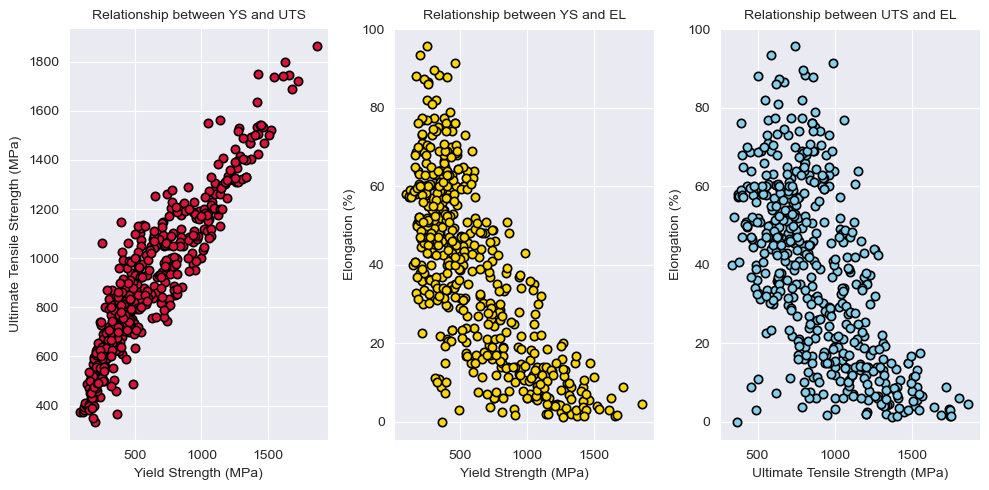

In [332]:
plt.figure(figsize = (10, 5))
sns.set_style("darkgrid")

# illustrate the relationship between the YS and UTS
plt.subplot(1, 3, 1)
sns.scatterplot(x = "yield_strength", 
                y = "ultimate_tensile_strength", 
                data = hea_ed_df_copy, 
                edgecolor = "black",
                linewidth = 1.2,
                color = "crimson")
plt.title("Relationship between YS and UTS", fontsize = 10)
plt.xlabel("Yield Strength (MPa)", fontsize = 10)
plt.ylabel("Ultimate Tensile Strength (MPa)", fontsize = 10)

# illustrate the relationship between the YS and EL
plt.subplot(1, 3, 2)
sns.scatterplot(x = "yield_strength", 
                y = "elongation", 
                data = hea_ed_df_copy, 
                edgecolor = "black",
                linewidth = 1.2,
                color = "gold")
plt.title("Relationship between YS and EL", fontsize = 10)
plt.xlabel("Yield Strength (MPa)", fontsize = 10)
plt.ylabel("Elongation (%)", fontsize = 10)

# illustrate the relationship between the UTS and EL
plt.subplot(1, 3, 3)
sns.scatterplot(x = "ultimate_tensile_strength", 
                y = "elongation", 
                data = hea_ed_df_copy, 
                edgecolor = "black",
                linewidth = 1.2,
                color = "skyblue")
plt.title("Relationship between UTS and EL", fontsize = 10)
plt.xlabel("Ultimate Tensile Strength (MPa)", fontsize = 10)
plt.ylabel("Elongation (%)", fontsize = 10)

plt.tight_layout()
plt.show()

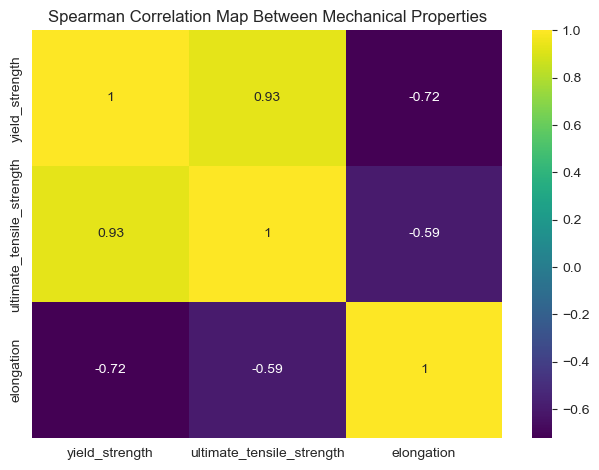

In [333]:
# visualize the correlation between the target variables 
sns.set_style("darkgrid")
sns.heatmap(hea_ed_df_copy[['yield_strength', 'ultimate_tensile_strength', 'elongation']].corr(method = "spearman"), 
            annot = True, 
            cmap = "viridis")
plt.title("Spearman Correlation Map Between Mechanical Properties")
plt.tight_layout()
plt.show()

In [334]:
# calculate the Spearman correlation and p-value between YS and UTS 
corr1, p_val1 = spearmanr(hea_ed_df_copy['yield_strength'], hea_ed_df_copy['ultimate_tensile_strength'])
# calculate the Spearman correlation and p-value between YS and EL 
corr2, p_val2 = spearmanr(hea_ed_df_copy['yield_strength'], hea_ed_df_copy['elongation'])
# calculate the Spearman correlation and p-value between UTS and EL 
corr3, p_val3 = spearmanr(hea_ed_df_copy['ultimate_tensile_strength'], hea_ed_df_copy['elongation'])

# display the outcomes 
print("The correlation between YS and UTS is {:.4f} and the p-value is {:.4f}.".format(corr1, p_val1))
print("The correlation between YS and EL is {:.4f} and the p-value is {:.4f}".format(corr2, p_val2))
print("The correlation between UTS and EL is {:.4f} and the p-value is {:.4f}".format(corr3, p_val3))

The correlation between YS and UTS is 0.9262 and the p-value is 0.0000.
The correlation between YS and EL is -0.7215 and the p-value is 0.0000
The correlation between UTS and EL is -0.5950 and the p-value is 0.0000


### **(C) Distribution of Mechanical Properties**

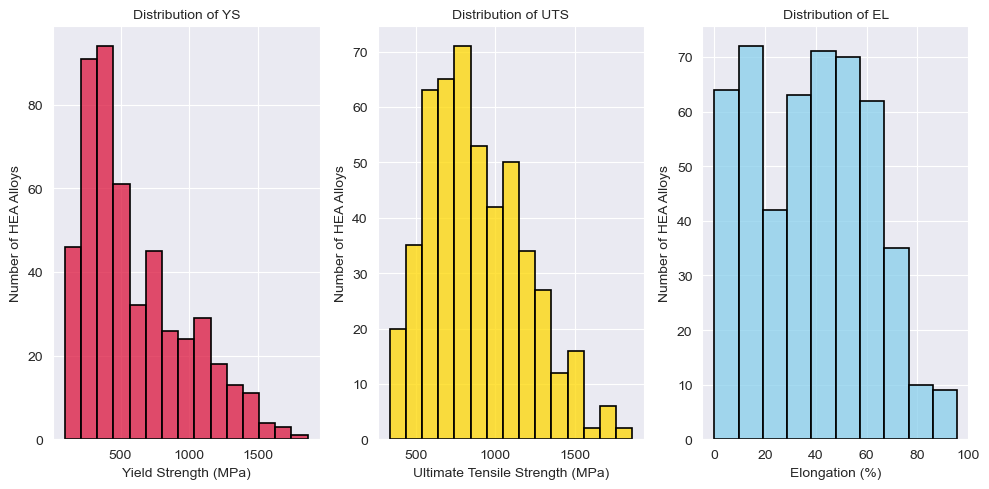

In [335]:
plt.figure(figsize = (10, 5))
sns.set_style("darkgrid")

# illustrate the distribution of YS
plt.subplot(1, 3, 1)
sns.histplot(data = hea_ed_df_copy['yield_strength'], 
            edgecolor = "black",
            linewidth = 1.2,
            color = "crimson")
plt.title("Distribution of YS", fontsize = 10)
plt.xlabel("Yield Strength (MPa)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

# illustrate the distribution of UTS
plt.subplot(1, 3, 2)
sns.histplot(data = hea_ed_df_copy['ultimate_tensile_strength'], 
                edgecolor = "black",
                linewidth = 1.2,
                color = "gold")
plt.title("Distribution of UTS", fontsize = 10)
plt.xlabel("Ultimate Tensile Strength (MPa)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

# illustrate the distribution of EL
plt.subplot(1, 3, 3)
sns.histplot(data = hea_ed_df_copy['elongation'], 
            edgecolor = "black",
            linewidth = 1.2,
            color = "skyblue")
plt.title("Distribution of EL", fontsize = 10)
plt.xlabel("Elongation (%)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

plt.tight_layout()
plt.show()

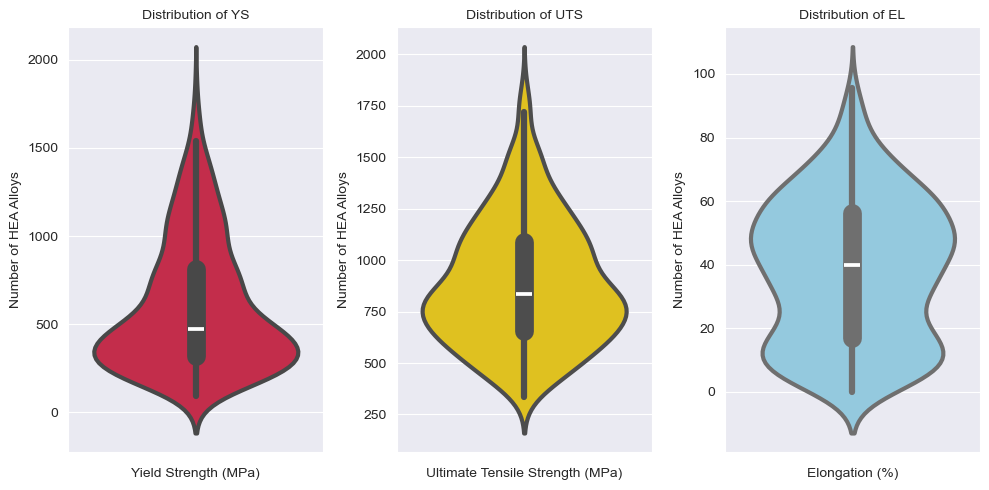

In [336]:
plt.figure(figsize = (10, 5))
sns.set_style("darkgrid")

# illustrate the distribution of YS
plt.subplot(1, 3, 1)
sns.violinplot(data = hea_ed_df_copy['yield_strength'], 
            linewidth = 3,
            color = "crimson")
plt.title("Distribution of YS", fontsize = 10)
plt.xlabel("Yield Strength (MPa)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

# illustrate the distribution of UTS
plt.subplot(1, 3, 2)
sns.violinplot(data = hea_ed_df_copy['ultimate_tensile_strength'], 
                linewidth = 3,
                color = "gold")
plt.title("Distribution of UTS", fontsize = 10)
plt.xlabel("Ultimate Tensile Strength (MPa)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

# illustrate the distribution of EL
plt.subplot(1, 3, 3)
sns.violinplot(data = hea_ed_df_copy['elongation'], 
            linewidth = 3,
            color = "skyblue")
plt.title("Distribution of EL", fontsize = 10)
plt.xlabel("Elongation (%)", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)

plt.tight_layout()
plt.show()

### **(D) Distribution Between UTS > YS, UTS < YS, and UTS == YS**

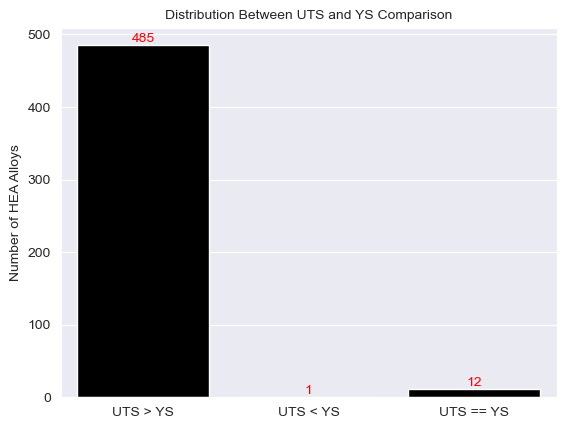

In [337]:
# counting the number of alloys where UTS > YS
uts_gt_ys = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] > hea_ed_df_copy['yield_strength']])
# counting the number of alloys where UTS < YS
uts_ls_ys = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] < hea_ed_df_copy['yield_strength']])
# counting the number of alloys where UTS == YS
uts_eq_ys = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] == hea_ed_df_copy['yield_strength']])

# creating a bar plot to visualize the distribution between UTS and YS comparison 
sns.set_style("darkgrid")
ax = sns.barplot(x = ["UTS > YS", "UTS < YS", "UTS == YS"], y = [uts_gt_ys, uts_ls_ys, uts_eq_ys], color = 'k')
plt.title("Distribution Between UTS and YS Comparison", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)
# adding count values above the bars
for bar, value in zip(ax.patches, [uts_gt_ys, uts_ls_ys, uts_eq_ys]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{value}', ha='center', va='bottom', color = 'red')
plt.show()

### **(E) Distribution of + and - YS, UTS, and EL**

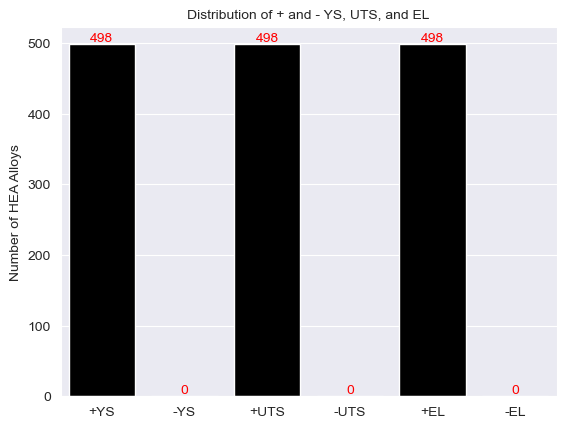

In [338]:
# counting the number of alloys with - YS
neg_ys = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] < 0])
# counting the number of alloys with + YS
pos_ys = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] >= 0])
# counting the number of alloys with - UTS
neg_uts = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] < 0])
# counting the number of alloys with + UTS
pos_uts = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] >= 0])
# counting the number of alloys with - EL
neg_el = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] < 0])
# counting the number of alloys with + EL
pos_el = len(hea_ed_df_copy[hea_ed_df_copy['ultimate_tensile_strength'] >= 0])

# creating a bar plot to visualize the distribution of + and - YS, UTS, and EL
sns.set_style("darkgrid")
ax = sns.barplot(x = ["+YS", "-YS", "+UTS", "-UTS", "+EL", "-EL"], y = [pos_ys, neg_ys, pos_uts, neg_uts, pos_el, neg_el], color = 'k')
plt.title("Distribution of + and - YS, UTS, and EL", fontsize = 10)
plt.ylabel("Number of HEA Alloys", fontsize = 10)
# adding count values above the bars
for bar, value in zip(ax.patches, [pos_ys, neg_ys, pos_uts, neg_uts, pos_el, neg_el]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{value}', ha='center', va='bottom', color = 'red')
plt.show()

### **(F) Distribution of Processing Properties and Elemental Descriptors**

In [339]:
input_features = hea_ed_df_copy.drop(['yield_strength', 'ultimate_tensile_strength', 'elongation'], axis = 1)
input_features_names = input_features.columns

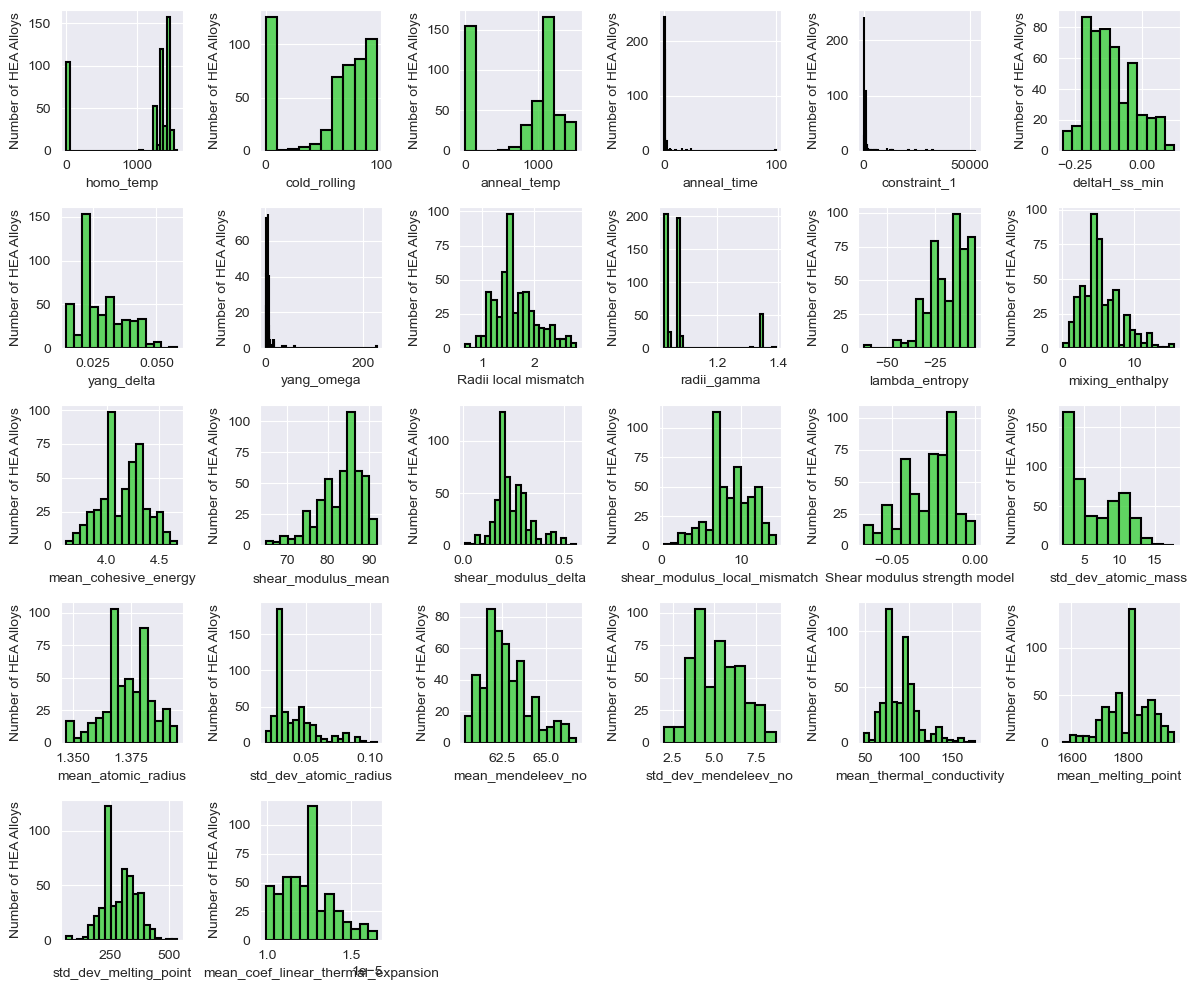

In [340]:
# illustrate the distribution of the respective 27 features 
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
for i in range(len(input_features_names)):
    plt.subplot(5, 6, i+1)
    sns.histplot(data = input_features[input_features_names[i]], 
                 linewidth = 1.5, 
                 edgecolor = "k", 
                 color = "limegreen")
    plt.ylabel("Number of HEA Alloys")
plt.tight_layout()
plt.show()

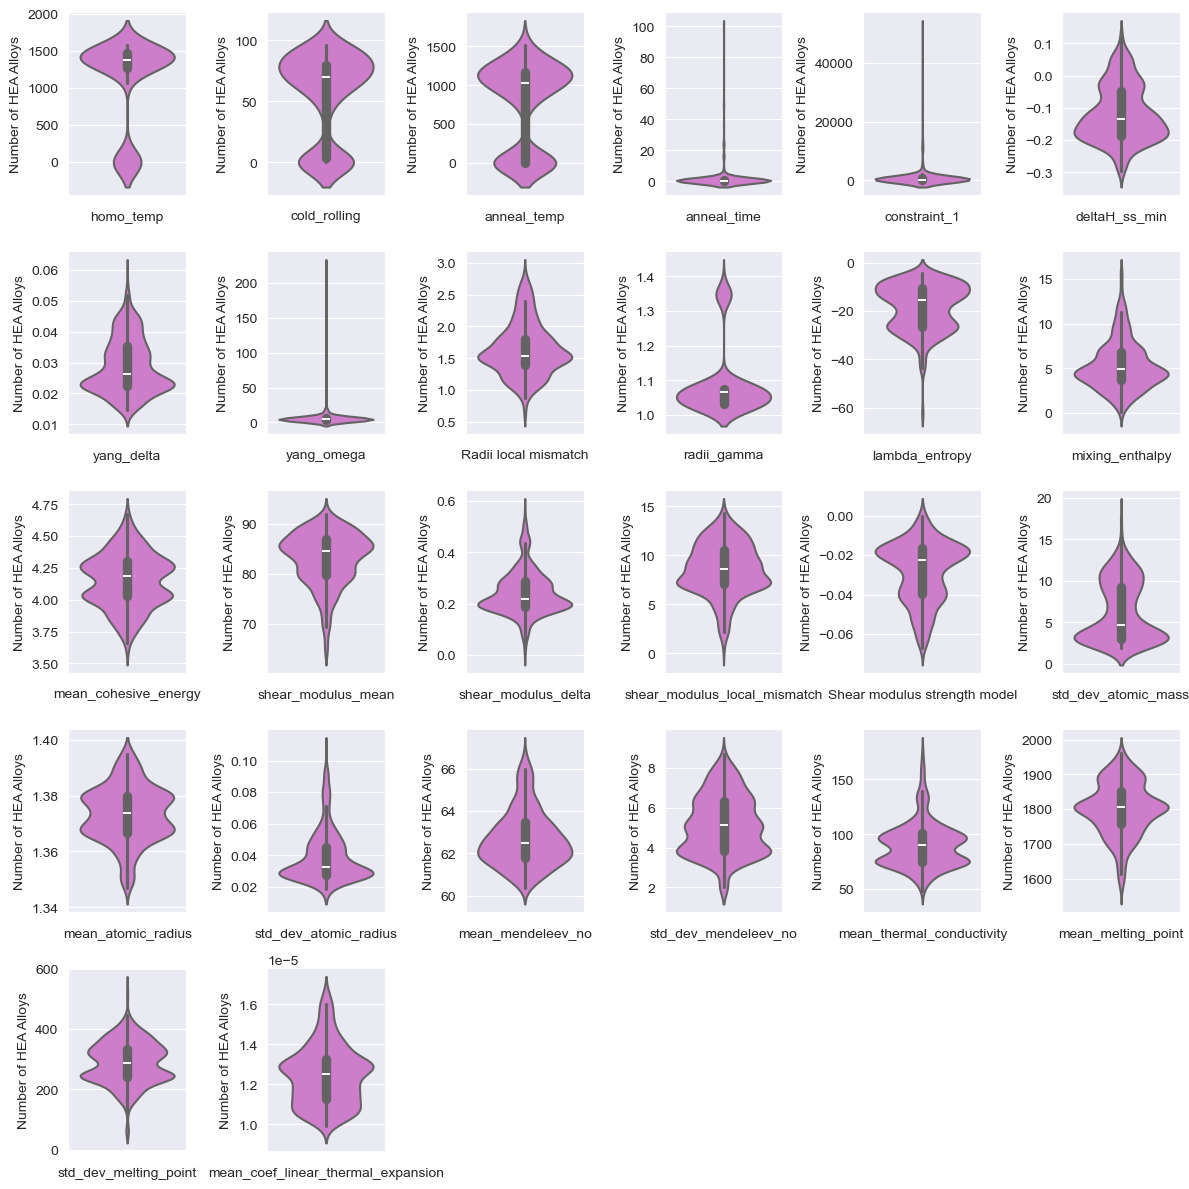

In [341]:
# illustrate the distribution of the respective 27 features 
plt.figure(figsize = (12, 12))
sns.set_style("darkgrid")
for i in range(len(input_features_names)):
    plt.subplot(5, 6, i+1)
    sns.violinplot(data = input_features[input_features_names[i]], 
                   linewidth = 1.5,
                   color = "orchid")
    plt.xlabel(input_features_names[i])
    plt.ylabel("Number of HEA Alloys")
plt.tight_layout()
plt.show()

### **(G) Relationship of Processing Properties and Elemental Descriptors with YS**

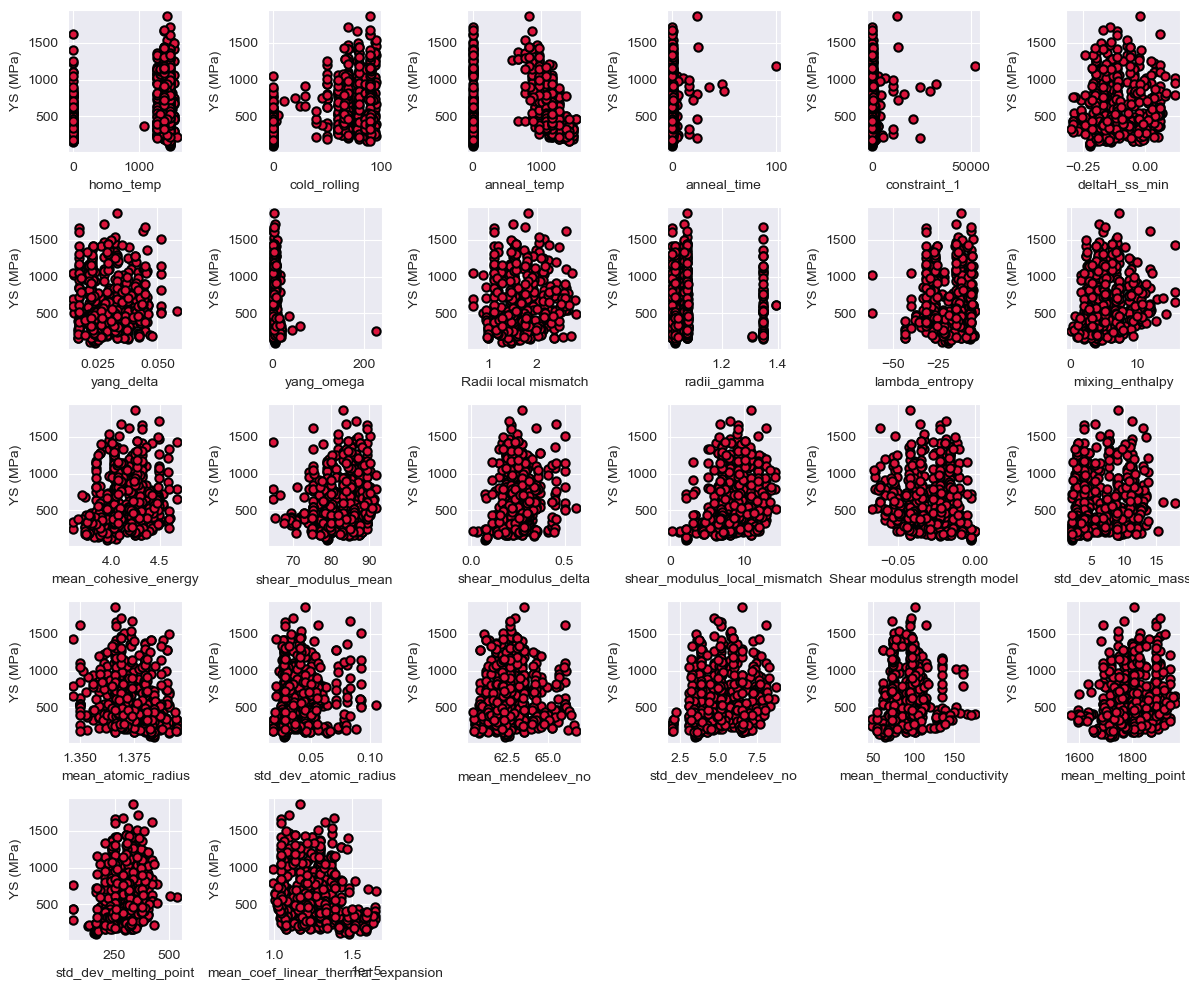

In [342]:
# illustrate the relationship between respective 27 features with YS
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
for i in range(len(input_features_names)):
    plt.subplot(5, 6, i+1)
    sns.scatterplot(x = input_features_names[i], 
                 y = "yield_strength",
                 data = hea_ed_df_copy, 
                 linewidth = 1.5, 
                 edgecolor = "k", 
                 color = "crimson")
    plt.ylabel("YS (MPa)")
plt.tight_layout()
plt.show()

### **(H) Relationship of Processing Properties and Elemental Descriptors with UTS**

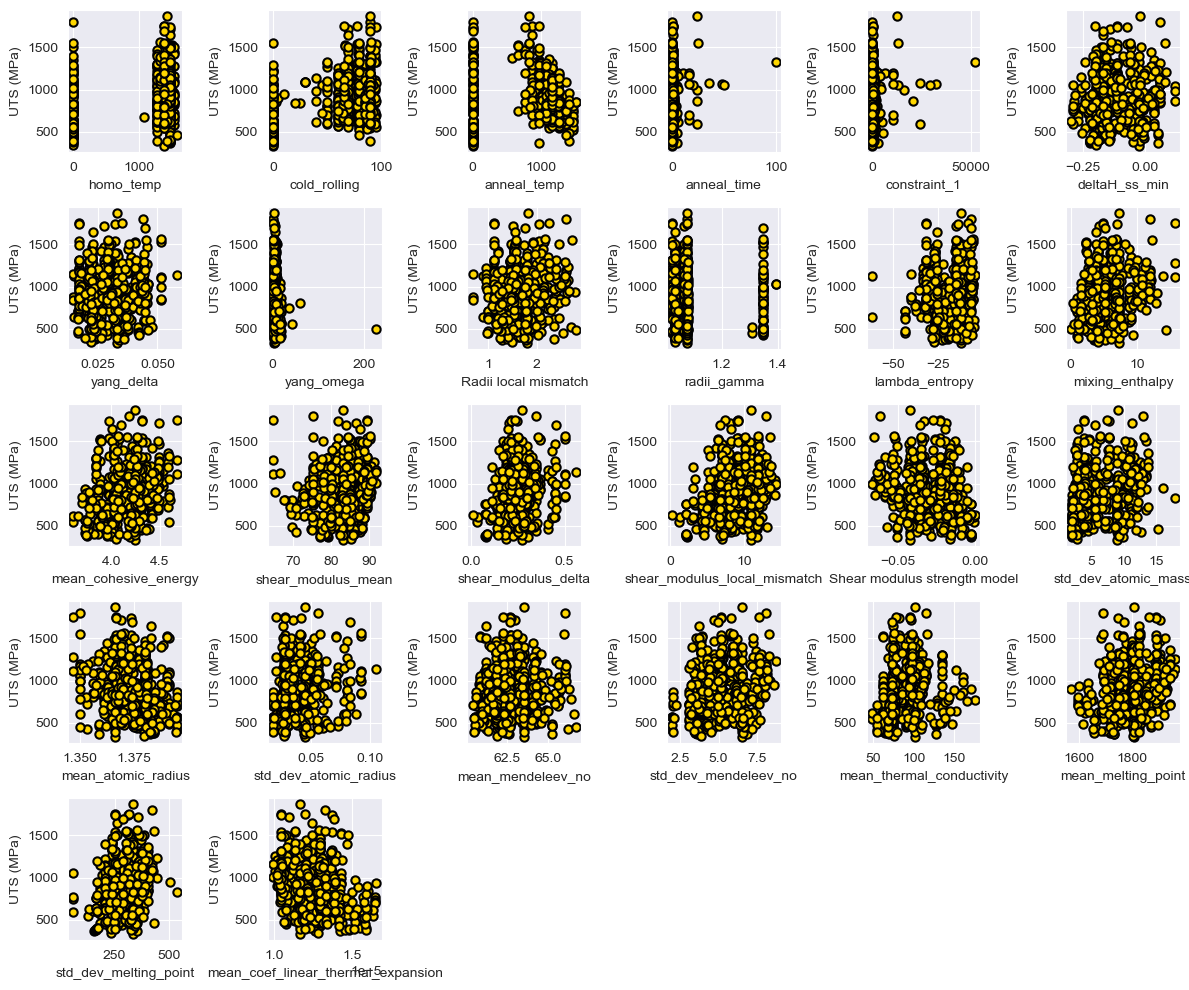

In [343]:
# illustrate the relationship between respective 27 features with UTS
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
for i in range(len(input_features_names)):
    plt.subplot(5, 6, i+1)
    sns.scatterplot(x = input_features_names[i], 
                 y = "ultimate_tensile_strength",
                 data = hea_ed_df_copy, 
                 linewidth = 1.5, 
                 edgecolor = "k", 
                 color = "gold")
    plt.ylabel("UTS (MPa)")
plt.tight_layout()
plt.show()

### **(I) Relationship of Processing Properties and Elemental Descriptors with EL**

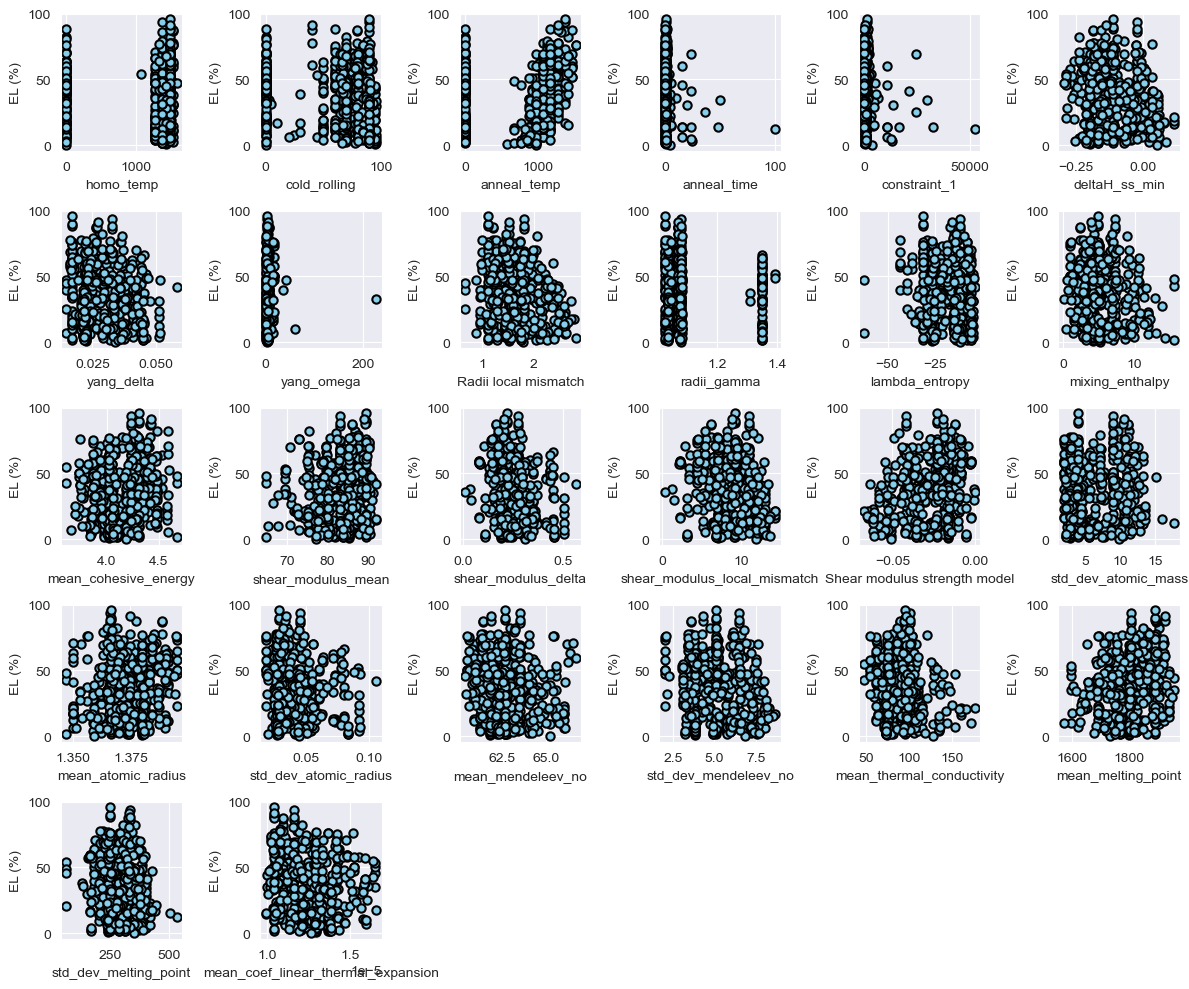

In [344]:
# illustrate the relationship between respective 27 features with UTS
plt.figure(figsize = (12, 10))
sns.set_style("darkgrid")
for i in range(len(input_features_names)):
    plt.subplot(5, 6, i+1)
    sns.scatterplot(x = input_features_names[i], 
                 y = "elongation",
                 data = hea_ed_df_copy, 
                 linewidth = 1.5, 
                 edgecolor = "k", 
                 color = "skyblue")
    plt.ylabel("EL (%)")
plt.tight_layout()
plt.show()

### **(J) 3D Relationship between Mechanical Properties**

In [345]:
import plotly.express as px
# illustrate the 3d relationship between mechanical properties
fig = px.scatter_3d(hea_ed_df_copy, x='yield_strength', y='ultimate_tensile_strength', z='elongation')
fig.show()

## **(4) Data Splitting**

In [346]:
 # extract the features and target variables
X = hea_ed_df_copy.drop(['yield_strength', 'ultimate_tensile_strength', 'elongation'], axis = 1)
y = hea_ed_df_copy[['yield_strength', 'ultimate_tensile_strength', 'elongation']]    

# call the data_splitting function to split the data into training and testing sets
X_train_ed, X_test_ed, y_train_ed, y_test_ed = train_test_split(X, y, 
                                                                shuffle = True, 
                                                                test_size = 0.25, 
                                                                random_state = 32)

# display the shape of the data splitting
print(X_train_ed.shape)
print(X_test_ed.shape)
print(y_train_ed.shape)
print(y_test_ed.shape)

# save the training file
train_df = pd.concat([X_train_ed, y_train_ed], axis = 1)
train_df.to_csv('train_df.csv', index = True)

(373, 26)
(125, 26)
(373, 3)
(125, 3)


In [347]:
y_train_original = y_train_ed.copy()

## **(5) Data Transformation**

In [348]:
# extract the column name
fea_cols_name = X_train_ed.columns
# initialize the standard scaler object for scaling
standard_scaler = StandardScaler()
# scaling the training data features using the fit_transform method with the selected feature columns
X_train_ed[fea_cols_name] = standard_scaler.fit_transform(X_train_ed[fea_cols_name])
# scaling the test data features using the transform method with the selected feature columns
X_test_ed[fea_cols_name] = standard_scaler.transform(X_test_ed[fea_cols_name])
X_train_ed

homo_temp  cold_rolling  anneal_temp  anneal_time  constraint_1  \
234   0.438615     -0.144903     0.308334    -0.081506     -0.117422   
348  -1.947512      0.997238    -1.418179    -0.280852     -0.307648   
42    0.612405     -0.144903     0.308334    -0.247628     -0.275944   
447   0.612405      0.283400     0.588916    -0.081506     -0.071622   
255  -1.947512      0.997238    -1.418179    -0.280852     -0.307648   
..         ...           ...          ...          ...           ...   
403   0.612405      0.426167     0.588916    -0.247627     -0.268310   
329   0.612405      0.140632     0.775970     0.117839      0.225473   
413   0.438615      0.711702    -1.418179    -0.280852     -0.307648   
48    0.264826      0.711702     1.150079    -0.181179     -0.143834   
230   0.612405      0.671728     0.963024    -0.231015     -0.233375   

     deltaH_ss_min  yang_delta  yang_omega  Radii local mismatch  radii_gamma  \
234      -0.912638   -0.703833   -0.027736             -0.282347    -0.554455   
348       0.362279    0.392238   -0.210813              1.118882    -0.115773   
42       -0.757946   -0.703833    0.036508             -0.282347    -0.554455   
447      -0.912638   -0.703833   -0.027736             -0.282347    -0.554455   
255       2.137844    1.742925   -0.346089              2.408301    -0.116270   
..             ...         ...         ...                   ...          ...   
403      -0.746567   -0.765483    0.133720             -0.545696    -0.554030   
329       0.014174   -0.583148   -0.187952             -0.542569    -0.211099   
413       0.695257    0.034109   -0.196139             -0.172630    -0.112747   
48       -0.396755    1.922461   -0.165282              0.880466     2.668364   
230       1.329378    0.912708   -0.261798              1.801616    -0.116340   

     ...  Shear modulus strength model  std_dev_atomic_mass  \
234  ...                      0.772914            -0.948272   
348  ...                      0.042167             0.379100   
42   ...                      0.862308            -1.045000   
447  ...                      0.772914            -0.948272   
255  ...                     -2.321153             1.866419   
..   ...                           ...                  ...   
403  ...                      0.836725            -0.978548   
329  ...                      0.363134             0.837625   
413  ...                     -0.506689             0.431335   
48   ...                     -1.042077            -0.163678   
230  ...                     -1.164730             0.941240   

     mean_atomic_radius  std_dev_atomic_radius  mean_mendeleev_no  \
234            0.625532              -0.723355          -0.683363   
348            0.878326               0.176019          -0.224799   
42             1.636707              -0.955774          -1.149698   
447            0.625532              -0.723355          -0.683363   
255           -2.407992               1.041475           2.593888   
..                  ...                    ...                ...   
403            1.080561              -0.786073          -1.064203   
329           -0.451369              -0.373104          -0.176611   
413           -0.481704               0.113149           0.323067   
48            -0.062067               2.493982          -0.425324   
230           -0.569373               0.561145           0.602464   

     std_dev_mendeleev_no  mean_thermal_conductivity  mean_melting_point  \
234             -0.902733                  -0.752756           -0.006204   
348              0.505537                  -0.901531           -1.154336   
42              -0.905752                  -0.941916            0.105801   
447             -0.902733                  -0.752756           -0.006204   
255              2.041850                   1.148564           -1.428155   
..                    ...                        ...                 ...   
403             -1.188728                  -0.628

In [349]:
# initialize the min max scaler object for scaling
min_max_scaler = MinMaxScaler()
# scaling the train target features using the fit_transform method with the selected target columns
y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.fit_transform(y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
# scaling the test target features using the transform method with the selected target columns
y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.transform(y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
y_train_ed

yield_strength  ultimate_tensile_strength  elongation
234        0.299943                   0.340537    0.529843
348        0.655348                   0.692207    0.084817
42         0.365025                   0.304519    0.166492
447        0.121675                   0.199083    0.547644
255        0.865874                   0.959398    0.061780
..              ...                        ...         ...
403        0.189587                   0.283563    0.704712
329        0.209394                   0.377865    0.737173
413        0.565365                   0.569745    0.099476
48         0.161290                   0.311067    0.690052
230        0.359366                   0.414538    0.303665

[373 rows x 3 columns]

In [350]:
sdsdsdsdsd

NameError: name 'sdsdsdsdsd' is not defined

## **(6) DNN-Multioutput Regressor**

##### **Custom Permutation Feature Importances**

In [ ]:
def permutation_importance(model, X_train, y_train, n_repeats):
  importance = np.zeros(X_train.shape[1]) # initialize importance scores for features
  for i in range(X_train.shape[1]):
    for _ in range(n_repeats):
      # randomly shuffle a single feature
      shuffled_X = X_train.copy()
      shuffled_X.iloc[:, i] = np.random.permutation(shuffled_X.iloc[:, i])
      # evaluate model performance with shuffled feature (using R²)
      y_pred = model.predict(shuffled_X)
      base_score = r2_score(y_train, model.predict(X_train))
      permuted_score = r2_score(y_train, y_pred)
      # Calculate importance drop (difference in R²)
      importance[i] += base_score - permuted_score
  
  # store the importances 
  importances = importance / n_repeats
  
  # create a feature name list 
  feature_names = X_train.columns
  # sort features and importance scores together by importance (descending)
  sorted_idx = importances.argsort()[::-1]
  sorted_features = np.array(feature_names)[sorted_idx]
  sorted_importance = importances[sorted_idx]
  # store the sorted features and sorted importances into the dataframe 
  feature_importance_df = pd.DataFrame({'feature_name': sorted_features, 
                                        'importances': sorted_importance})

  # create a plot for feature importances 
  plt.figure(figsize=(10, 6))
  sns.set_style("darkgrid")
  ax = sns.barplot(data = feature_importance_df, x = "importances", y = "feature_name", color='black')
  plt.xlabel("Permutation Importance Score")
  plt.ylabel("Features")
  plt.title("Overall Permutation Feature Importance for DNN-Multioutput Regressor")
  plt.xticks(rotation=90, ha='right')

  plt.tight_layout()
  plt.show()


##### **Custom MSE Loss Function**

In [ ]:
def custom_mse_loss(y_true, y_pred):
    # define min and max values
    ymin_64 = tf.cast(tf.reduce_min(y_train_ed), dtype=tf.float64)
    ymax_64 = tf.cast(tf.reduce_max(y_train_ed), dtype=tf.float64)

    # cast y_pred and y_true to float64
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    y_true = tf.cast(y_true, dtype=tf.float64)

    # inverse transform min_max_scaling
    y_pred = ymin_64 + (ymax_64 - ymin_64) * y_pred
    y_true = ymin_64 + (ymax_64 - ymin_64) * y_true

    # extract the YS, UTS
    ys = y_pred[:, 0] # extract YS only
    uts = y_pred[:, 1] # extract UTS only 

    # check if UTS is less than YS (violation)
    condition_check = tf.less(uts, ys)
    
    # calculate the magnitude based on the violation check 
    magnitude = tf.where(condition_check, 
                        tf.abs(uts - ys), 
                        tf.constant(0.0, dtype = tf.float64))
    
    # compute the actual MSE loss before penalty 
    actual_mse_loss = tf.cast(tf.reduce_mean(tf.square(y_true - y_pred)), dtype = tf.float64)

    # determine the penalty based on magnitude 
    penalty = magnitude * actual_mse_loss
        
    # compute the overall MSE loss with inclusive of penalty 
    total_mse_loss = actual_mse_loss + penalty

    return total_mse_loss


### **(A) Validate Baseline Model with Random Parameters**

In [ ]:
def dnn_bl_mo():
    dnn_mo = Sequential()
    dnn_mo.add(Dense(64, kernel_initializer = "LecunUniform", input_dim = 26, activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(32, kernel_initializer = "LecunUniform", activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(16, kernel_initializer = "LecunUniform", activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(3, activation = "relu"))
    return dnn_mo

#### **K-Fold Cross-Validation Approach**

In [ ]:
# initialize lists to store train and validation scores for each target variables and for each fold 
dnn_bl_ed_cv_train_r2Scores_ys_data = list() 
dnn_bl_ed_cv_train_r2Scores_uts_data = list()
dnn_bl_ed_cv_train_r2Scores_el_data = list() 
dnn_bl_ed_cv_train_r2Scores_ys_uts_data = list() 
dnn_bl_ed_cv_val_r2Scores_ys_data = list() 
dnn_bl_ed_cv_val_r2Scores_uts_data = list()
dnn_bl_ed_cv_val_r2Scores_el_data = list() 
dnn_bl_ed_cv_val_r2Scores_ys_uts_data = list() 

dnn_bl_ed_cv_train_rmse_ys_data = list()
dnn_bl_ed_cv_train_rmse_uts_data = list()
dnn_bl_ed_cv_train_rmse_el_data = list()
dnn_bl_ed_cv_train_rmse_ys_uts_data = list()
dnn_bl_ed_cv_val_rmse_ys_data = list()
dnn_bl_ed_cv_val_rmse_uts_data = list()
dnn_bl_ed_cv_val_rmse_el_data = list()
dnn_bl_ed_cv_val_rmse_ys_uts_data = list()

# initialize the KFold cross-validator 
kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# iterate through each fold 
for train_index, val_index in kf_cv.split(X_train_ed):

    # split the data into training and validation sets for the current fold 
    X_train_bl_cv, X_val_bl_cv = X_train_ed.iloc[train_index], X_train_ed.iloc[val_index]
    y_train_bl_cv, y_val_bl_cv = y_train_ed.iloc[train_index], y_train_ed.iloc[val_index]
    
    with tf.device("/CPU"):
        # define base model 
        dnn_bl_ed_cv = KerasRegressor(model = dnn_bl_mo, 
                                    loss = custom_mse_loss, 
                                    batch_size = 32, 
                                    epochs = 250, 
                                    optimizer = Adamax(learning_rate = 0.01),
                                    metrics = [R2Score, RootMeanSquaredError],
                                    random_state = 42)

        # fit the model on training data
        dnn_bl_ed_cv.fit(X_train_bl_cv, y_train_bl_cv, shuffle = True)

        # predictions on training and validation data
        dnn_bl_ed_cv_train_predict = dnn_bl_ed_cv.predict(X_train_bl_cv)
        dnn_bl_ed_cv_val_predict = dnn_bl_ed_cv.predict(X_val_bl_cv)

        # compute train scores (R2 and RMSE) for yield_strength + ultimate tensile strength
        dnn_bl_ed_cv_train_r2Scores_ys_uts = r2_score(y_train_bl_cv[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_cv_train_predict[:, [0, 1]])
        dnn_bl_ed_cv_train_rmse_ys_uts = np.sqrt(mean_squared_error(y_train_bl_cv[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_cv_train_predict[:, [0, 1]]))
        # append scores to respective lists for yield_strength + ultimate tensile strength
        dnn_bl_ed_cv_train_r2Scores_ys_uts_data.append(dnn_bl_ed_cv_train_r2Scores_ys_uts)
        dnn_bl_ed_cv_train_rmse_ys_uts_data.append(dnn_bl_ed_cv_train_rmse_ys_uts)

        # compute validation scores (R2 and RMSE) for yield_strength + ultimate tensile strength
        dnn_bl_ed_cv_val_r2Scores_ys_uts = r2_score(y_val_bl_cv[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_cv_val_predict[:, [0, 1]])
        dnn_bl_ed_cv_val_rmse_ys_uts = np.sqrt(mean_squared_error(y_val_bl_cv[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_cv_val_predict[:, [0, 1]]))
        # append scores to respective lists for yield_strength + ultimate tensile strength
        dnn_bl_ed_cv_val_r2Scores_ys_uts_data.append(dnn_bl_ed_cv_val_r2Scores_ys_uts)
        dnn_bl_ed_cv_val_rmse_ys_uts_data.append(dnn_bl_ed_cv_val_rmse_ys_uts)


        # compute train scores (R2 and RMSE) for yield_strength 
        dnn_bl_ed_cv_train_r2Scores_ys = r2_score(y_train_bl_cv['yield_strength'], dnn_bl_ed_cv_train_predict[:, 0])
        dnn_bl_ed_cv_train_rmse_ys = np.sqrt(mean_squared_error(y_train_bl_cv['yield_strength'], dnn_bl_ed_cv_train_predict[:, 0]))
        # append scores to respective lists for yield strength
        dnn_bl_ed_cv_train_r2Scores_ys_data.append(dnn_bl_ed_cv_train_r2Scores_ys)
        dnn_bl_ed_cv_train_rmse_ys_data.append(dnn_bl_ed_cv_train_rmse_ys)

        # compute validation scores (R2 and RMSE) for yield_strength 
        dnn_bl_ed_cv_val_r2Scores_ys = r2_score(y_val_bl_cv['yield_strength'], dnn_bl_ed_cv_val_predict[:, 0])
        dnn_bl_ed_cv_val_rmse_ys = np.sqrt(mean_squared_error(y_val_bl_cv['yield_strength'], dnn_bl_ed_cv_val_predict[:, 0]))
        # append scores to respective lists for yield strength
        dnn_bl_ed_cv_val_r2Scores_ys_data.append(dnn_bl_ed_cv_val_r2Scores_ys)
        dnn_bl_ed_cv_val_rmse_ys_data.append(dnn_bl_ed_cv_val_rmse_ys)


        # compute train scores (R2 and RMSE) for ultimate tensile strength 
        dnn_bl_ed_cv_train_r2Scores_uts = r2_score(y_train_bl_cv['ultimate_tensile_strength'], dnn_bl_ed_cv_train_predict[:, 1])
        dnn_bl_ed_cv_train_rmse_uts = np.sqrt(mean_squared_error(y_train_bl_cv['ultimate_tensile_strength'], dnn_bl_ed_cv_train_predict[:, 1]))
        # append scores to respective lists for ultimate tensile strength
        dnn_bl_ed_cv_train_r2Scores_uts_data.append(dnn_bl_ed_cv_train_r2Scores_uts)
        dnn_bl_ed_cv_train_rmse_uts_data.append(dnn_bl_ed_cv_train_rmse_uts)

        # compute validation scores (R2 and RMSE) for ultimate tensile strength 
        dnn_bl_ed_cv_val_r2Scores_uts = r2_score(y_val_bl_cv['ultimate_tensile_strength'], dnn_bl_ed_cv_val_predict[:, 1])
        dnn_bl_ed_cv_val_rmse_uts = np.sqrt(mean_squared_error(y_val_bl_cv['ultimate_tensile_strength'], dnn_bl_ed_cv_val_predict[:, 1]))
        # append scores to respective lists for ultimate tensile strength
        dnn_bl_ed_cv_val_r2Scores_uts_data.append(dnn_bl_ed_cv_val_r2Scores_uts)
        dnn_bl_ed_cv_val_rmse_uts_data.append(dnn_bl_ed_cv_val_rmse_uts)


        # compute train scores (R2 and RMSE) for elongation 
        dnn_bl_ed_cv_train_r2Scores_el = r2_score(y_train_bl_cv['elongation'], dnn_bl_ed_cv_train_predict[:, 2])
        dnn_bl_ed_cv_train_rmse_el = np.sqrt(mean_squared_error(y_train_bl_cv['elongation'], dnn_bl_ed_cv_train_predict[:, 2]))
        # append scores to respective lists for elongation
        dnn_bl_ed_cv_train_r2Scores_el_data.append(dnn_bl_ed_cv_train_r2Scores_el)
        dnn_bl_ed_cv_train_rmse_el_data.append(dnn_bl_ed_cv_train_rmse_el)

        # compute validation scores (R2 and RMSE) for elongation
        dnn_bl_ed_cv_val_r2Scores_el = r2_score(y_val_bl_cv['elongation'], dnn_bl_ed_cv_val_predict[:, 2])
        dnn_bl_ed_cv_val_rmse_el = np.sqrt(mean_squared_error(y_val_bl_cv['elongation'], dnn_bl_ed_cv_val_predict[:, 2]))
        # append scores to respective lists for elongation
        dnn_bl_ed_cv_val_r2Scores_el_data.append(dnn_bl_ed_cv_val_r2Scores_el)
        dnn_bl_ed_cv_val_rmse_el_data.append(dnn_bl_ed_cv_val_rmse_el)


Epoch 1/250
10/10 [==============================] - 0s 1ms/step - loss: 0.0983 - r2_score: -1.5649 - root_mean_squared_error: 0.3401
Epoch 2/250
10/10 [==============================] - 0s 856us/step - loss: 0.0661 - r2_score: -0.8510 - root_mean_squared_error: 0.2870
Epoch 3/250
10/10 [==============================] - 0s 878us/step - loss: 0.0537 - r2_score: -0.4531 - root_mean_squared_error: 0.2542
Epoch 4/250
10/10 [==============================] - 0s 783us/step - loss: 0.0396 - r2_score: -0.0734 - root_mean_squared_error: 0.2194
Epoch 5/250
10/10 [==============================] - 0s 908us/step - loss: 0.0348 - r2_score: 0.0999 - root_mean_squared_error: 0.2013
Epoch 6/250
10/10 [==============================] - 0s 825us/step - loss: 0.0279 - r2_score: 0.2864 - root_mean_squared_error: 0.1804
Epoch 7/250
10/10 [==============================] - 0s 829us/step - loss: 0.0251 - r2_score: 0.3255 - root_mean_squared_error: 0.1762
Epoch 8/250
10/10 [==============================] - 

**Validation Outcome for YS+UTS**

In [ ]:
# display the cross validation scores of the r-squared and rmse for yield strength + ultimate tensile strength
dnn_bl_ed_cv_res_ys_uts = pd.DataFrame({'R2 Score': [np.mean(dnn_bl_ed_cv_train_r2Scores_ys_uts_data), np.mean(dnn_bl_ed_cv_val_r2Scores_ys_uts_data)],  
                              'RMSE': [np.mean(dnn_bl_ed_cv_train_rmse_ys_uts_data), np.mean(dnn_bl_ed_cv_val_rmse_ys_uts_data)]})
dnn_bl_ed_cv_res_ys_uts.rename(index = {0: 'Train', 1: 'Validation'}, inplace = True)
dnn_bl_ed_cv_res_ys_uts

R2 Score      RMSE
Train       0.941582  0.049118
Validation  0.775746  0.095603

**Validation Outcome for YS**

In [ ]:
# display the cross validation scores of the r-squared and rmse for yield strength
dnn_bl_ed_cv_res_ys = pd.DataFrame({'R2 Score': [np.mean(dnn_bl_ed_cv_train_r2Scores_ys_data), np.mean(dnn_bl_ed_cv_val_r2Scores_ys_data)],  
                              'RMSE': [np.mean(dnn_bl_ed_cv_train_rmse_ys_data), np.mean(dnn_bl_ed_cv_val_rmse_ys_data)]})
dnn_bl_ed_cv_res_ys.rename(index = {0: 'Train', 1: 'Validation'}, inplace = True)
dnn_bl_ed_cv_res_ys

R2 Score      RMSE
Train       0.948336  0.046962
Validation  0.796430  0.092201

**Validation Outcome for UTS**

In [ ]:
# display the cross validation scores of the r-squared and rmse for ultimate tensile strength
dnn_bl_ed_cv_res_uts = pd.DataFrame({'R2 Score': [np.mean(dnn_bl_ed_cv_train_r2Scores_uts_data), np.mean(dnn_bl_ed_cv_val_r2Scores_uts_data)],  
                              'RMSE': [np.mean(dnn_bl_ed_cv_train_rmse_uts_data), np.mean(dnn_bl_ed_cv_val_rmse_uts_data)]})
dnn_bl_ed_cv_res_uts.rename(index = {0: 'Train', 1: 'Validation'}, inplace = True)
dnn_bl_ed_cv_res_uts

R2 Score      RMSE
Train       0.934827  0.051172
Validation  0.755063  0.098758

**Validation Outcome for EL**

In [ ]:
# display the cross validation scores of the r-squared and rmse for elongation
dnn_bl_ed_cv_res_el = pd.DataFrame({'R2 Score': [np.mean(dnn_bl_ed_cv_train_r2Scores_el_data), np.mean(dnn_bl_ed_cv_val_r2Scores_el_data)],  
                              'RMSE': [np.mean(dnn_bl_ed_cv_train_rmse_el_data), np.mean(dnn_bl_ed_cv_val_rmse_el_data)]})
dnn_bl_ed_cv_res_el.rename(index = {0: 'Train', 1: 'Validation'}, inplace = True)
dnn_bl_ed_cv_res_el

R2 Score      RMSE
Train       0.897725  0.075408
Validation  0.659031  0.137375

#### **Hold-Out Validation Approach**

In [ ]:
# training set for training
with tf.device("/CPU"):
    # define base model
    dnn_bl_ed = KerasRegressor(model = dnn_bl_mo, 
                                loss = custom_mse_loss, 
                                batch_size = 32, 
                                epochs = 250,
                                optimizer = Adamax(learning_rate = 0.01),
                                metrics = [R2Score, RootMeanSquaredError],
                                random_state = 42)
    # fit the baseline DNN regressor to the training data
    dnn_bl_ed.fit(X_train_ed, y_train_ed, shuffle = True)

Epoch 1/250
12/12 [==============================] - 0s 1ms/step - loss: 0.0970 - r2_score: -1.5275 - root_mean_squared_error: 0.3403
Epoch 2/250
12/12 [==============================] - 0s 973us/step - loss: 0.0654 - r2_score: -0.7381 - root_mean_squared_error: 0.2806
Epoch 3/250
12/12 [==============================] - 0s 817us/step - loss: 0.0494 - r2_score: -0.3057 - root_mean_squared_error: 0.2429
Epoch 4/250
12/12 [==============================] - 0s 805us/step - loss: 0.0330 - r2_score: 0.1146 - root_mean_squared_error: 0.2012
Epoch 5/250
12/12 [==============================] - 0s 887us/step - loss: 0.0282 - r2_score: 0.2913 - root_mean_squared_error: 0.1817
Epoch 6/250
12/12 [==============================] - 0s 872us/step - loss: 0.0261 - r2_score: 0.3064 - root_mean_squared_error: 0.1793
Epoch 7/250
12/12 [==============================] - 0s 831us/step - loss: 0.0260 - r2_score: 0.3237 - root_mean_squared_error: 0.1769
Epoch 8/250
12/12 [==============================] - 0

12/12 [==============================] - 0s 3ms/step


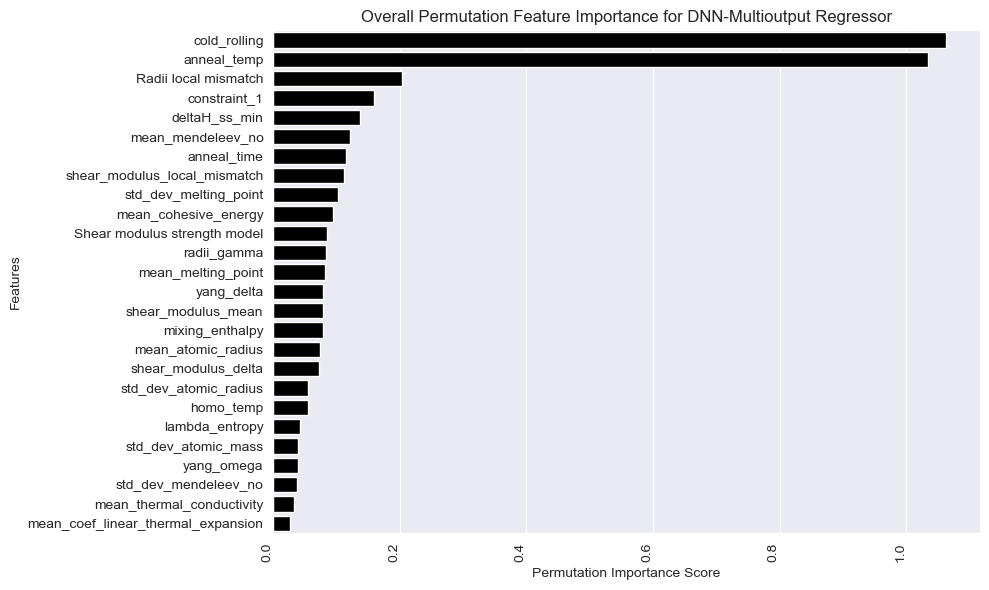

In [ ]:
# compute the permutation feature importances 
permutation_importance(dnn_bl_ed, X_train_ed, y_train_ed, 10)

In [ ]:
# use the trained baseline DNN regressor to predict both YS, UTS, and EL on the training set
dnn_bl_ed_train_predict = dnn_bl_ed.predict(X_train_ed)
# use the trained baseline DNN regressor to predict both YS, UTS, and EL on the testing set
dnn_bl_ed_test_predict = dnn_bl_ed.predict(X_test_ed)

# inverse transforming scaled back to original scale for training and testing set
y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.inverse_transform(y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.inverse_transform(y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
# inverse transforming predicted value back to original scale 
dnn_bl_ed_train_predict = min_max_scaler.inverse_transform(dnn_bl_ed_train_predict)
dnn_bl_ed_test_predict = min_max_scaler.inverse_transform(dnn_bl_ed_test_predict)

4/4 [==============================] - 0s 16ms/step


**Validation Outcome for YS+UTS**

In [ ]:
# outcome of ultimate tensile strength and elongation
# compute the r-squared score for the baseline DNN on the train set
dnn_bl_ed_train_r2_ys_uts = round(r2_score(y_train_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_train_predict[:, [0, 1]]), 3)
# compute the rmse score for the baseline DNN on the train set
dnn_bl_ed_train_rmse_ys_uts = round(np.sqrt(mean_squared_error(y_train_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_train_predict[:, [0, 1]])), 3)
# compute the r-squared score for the baseline DNN on the test set
dnn_bl_ed_test_r2_ys_uts = round(r2_score(y_test_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_test_predict[:, [0, 1]]), 3)
# compute the rmse score for the baseline DNN on the test set
dnn_bl_ed_test_rmse_ys_uts = round(np.sqrt(mean_squared_error(y_test_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_bl_ed_test_predict[:, [0, 1]])), 3)
# display the results
dnn_bl_ed_traintest_res_ys_uts = pd.DataFrame({'R2 Score': [dnn_bl_ed_train_r2_ys_uts, dnn_bl_ed_test_r2_ys_uts], 
                              'RMSE (MPa)': [dnn_bl_ed_train_rmse_ys_uts, dnn_bl_ed_test_rmse_ys_uts]})
dnn_bl_ed_traintest_res_ys_uts.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_bl_ed_traintest_res_ys_uts

R2 Score  RMSE (MPa)
Train     0.931      88.029
Test      0.826     136.673

**Validation Outcome for YS**

In [ ]:
# outcome of yield strength
# compute the r-squared score for the baseline DNN regressor on the train set
dnn_bl_ed_train_r2_ys = round(r2_score(y_train_ed['yield_strength'], dnn_bl_ed_train_predict[:, 0]), 3)
# compute the rmse score for the baseline DNN regressor the train set
dnn_bl_ed_train_rmse_ys = round(np.sqrt(mean_squared_error(y_train_ed['yield_strength'], dnn_bl_ed_train_predict[:, 0])), 3)
# compute the r-squared score for the baseline DNN regressor on the test set
dnn_bl_ed_test_r2_ys = round(r2_score(y_test_ed['yield_strength'], dnn_bl_ed_test_predict[:, 0]), 3)
# compute the rmse score for the baseline DNN regressor on the test set
dnn_bl_ed_test_rmse_ys = round(np.sqrt(mean_squared_error(y_test_ed['yield_strength'], dnn_bl_ed_test_predict[:, 0])), 3)
# display the results
dnn_bl_ed_traintest_res_ys = pd.DataFrame({'R2 Score': [dnn_bl_ed_train_r2_ys, dnn_bl_ed_test_r2_ys], 
                              'RMSE (MPa)': [dnn_bl_ed_train_rmse_ys, dnn_bl_ed_test_rmse_ys]})
dnn_bl_ed_traintest_res_ys.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_bl_ed_traintest_res_ys

R2 Score  RMSE (MPa)
Train     0.935      92.961
Test      0.849     143.214

**Validation Outcome for UTS**

In [ ]:
# outcome of ultimate tensile strength
# compute the r-squared score for the baseline DNN on the train set
dnn_bl_ed_train_r2_uts = round(r2_score(y_train_ed['ultimate_tensile_strength'], dnn_bl_ed_train_predict[:, 1]), 3)
# compute the rmse score for the baseline DNN  on the train set
dnn_bl_ed_train_rmse_uts = round(np.sqrt(mean_squared_error(y_train_ed['ultimate_tensile_strength'], dnn_bl_ed_train_predict[:, 1])), 3)
# compute the r-squared score for the baseline DNN  on the test set
dnn_bl_ed_test_r2_uts = round(r2_score(y_test_ed['ultimate_tensile_strength'], dnn_bl_ed_test_predict[:, 1]), 3)
# compute the rmse score for the baseline DNN  on the test set
dnn_bl_ed_test_rmse_uts = round(np.sqrt(mean_squared_error(y_test_ed['ultimate_tensile_strength'], dnn_bl_ed_test_predict[:, 1])), 3)
# display the results
dnn_bl_ed_traintest_res_uts = pd.DataFrame({'R2 Score': [dnn_bl_ed_train_r2_uts, dnn_bl_ed_test_r2_uts], 
                              'RMSE (MPa)': [dnn_bl_ed_train_rmse_uts, dnn_bl_ed_test_rmse_uts]})
dnn_bl_ed_traintest_res_uts.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_bl_ed_traintest_res_uts

R2 Score  RMSE (MPa)
Train     0.927      82.804
Test      0.803     129.802

**Validation Outcome for EL**

In [ ]:
# outcome of elongation
# compute the r-squared score for the baseline DNN on the train set
dnn_bl_ed_train_r2_el = round(r2_score(y_train_ed['elongation'], dnn_bl_ed_train_predict[:, 2]), 3)
# compute the rmse score for the baseline DNN on the train set
dnn_bl_ed_train_rmse_el = round(np.sqrt(mean_squared_error(y_train_ed['elongation'], dnn_bl_ed_train_predict[:, 2])), 3)
# compute the r-squared score for the baseline DNN on the test set
dnn_bl_ed_test_r2_el = round(r2_score(y_test_ed['elongation'], dnn_bl_ed_test_predict[:, 2]), 3)
# compute the rmse score for the baseline DNN on the test set
dnn_bl_ed_test_rmse_el = round(np.sqrt(mean_squared_error(y_test_ed['elongation'], dnn_bl_ed_test_predict[:, 2])), 3)
# display the results
dnn_bl_ed_traintest_res_el = pd.DataFrame({'R2 Score': [dnn_bl_ed_train_r2_el, dnn_bl_ed_test_r2_el], 
                              'RMSE (%)': [dnn_bl_ed_train_rmse_el, dnn_bl_ed_test_rmse_el]})
dnn_bl_ed_traintest_res_el.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_bl_ed_traintest_res_el

R2 Score  RMSE (%)
Train     0.893     7.392
Test      0.727    11.584

#### **Learning Curve**

##### **Losses**

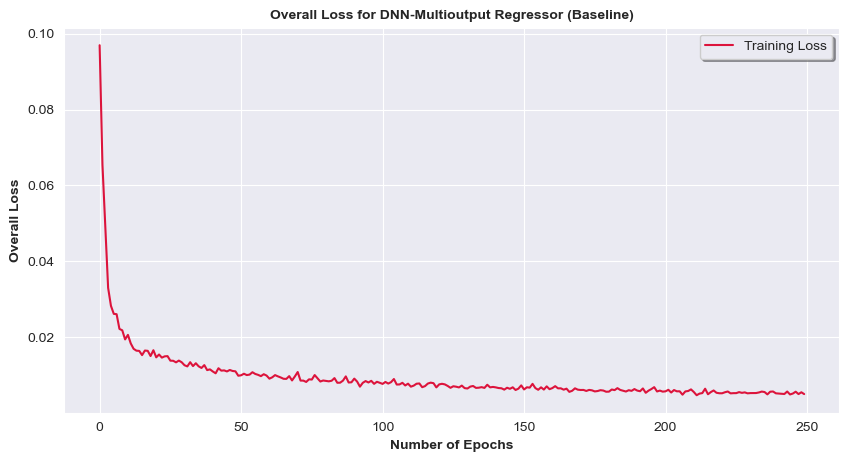

In [ ]:
# summarize history for losses
sns.set_style("darkgrid")
#set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_bl_ed.history_['loss'], color = "crimson", label = "Training Loss")
# set title
plt.title("Overall Loss for DNN-Multioutput Regressor (Baseline)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall Loss", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'upper right')
# show the plot
plt.show()

##### **RMSE**

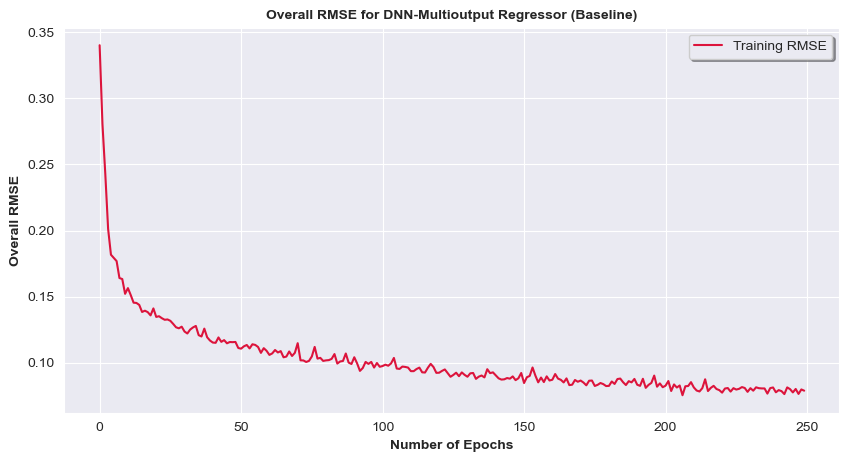

In [ ]:
# summarize history for RMSE
sns.set_style("darkgrid")
#set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_bl_ed.history_['root_mean_squared_error'], color = "crimson", label = "Training RMSE")
# set title
plt.title("Overall RMSE for DNN-Multioutput Regressor (Baseline)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall RMSE", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'upper right')
# show the plot
plt.show()

##### **R-Squared**

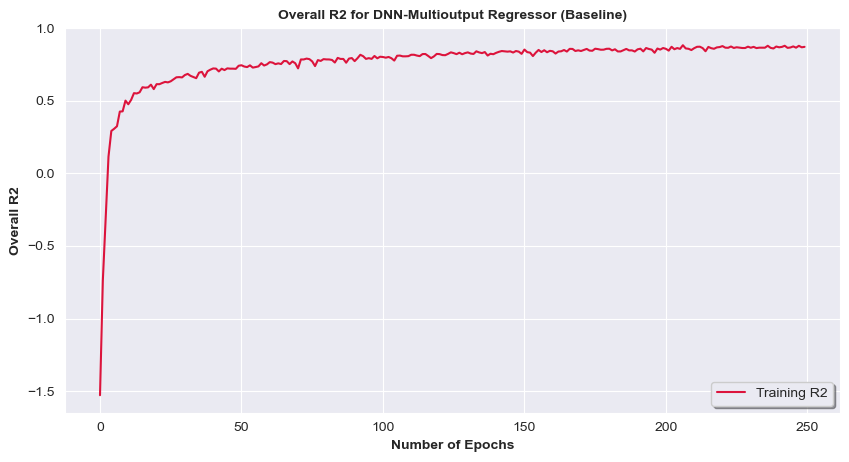

In [ ]:
# summarize history for R-squared
sns.set_style("darkgrid")
#set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_bl_ed.history_['r2_score'], color = "crimson", label = "Training R2")
# set title
plt.title("Overall R2 for DNN-Multioutput Regressor (Baseline)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall R2", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'lower right')
# show the plot
plt.show()

#### **Comparison Plot on Baseline Model with Default Parameters (Train Set and Test Set)**

In [ ]:
# training set
# create a copy of the training set 
dnn_bl_ed_train_df = y_train_ed.copy()
# renaming the columns 
dnn_bl_ed_train_df.rename(columns = {'yield_strength': 'Actual YS (MPa)', 
                               'ultimate_tensile_strength': 'Actual UTS (MPa)', 
                               'elongation': 'Actual EL (%)'}, inplace = True)
# adding columns 
dnn_bl_ed_train_df[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = dnn_bl_ed_train_predict
# displaying the dataframe
dnn_bl_ed_train_df

Actual YS (MPa)  Actual UTS (MPa)  Actual EL (%)  Predicted YS (MPa)  \
234            625.0             855.0           50.7          617.286804   
348           1253.0            1392.0            8.2         1192.796631   
42             740.0             800.0           16.0          689.653320   
447            310.0             639.0           52.4          394.781799   
255           1625.0            1800.0            6.0         1624.507080   
..               ...               ...            ...                 ...   
403            430.0             768.0           67.4          398.021301   
329            465.0             912.0           70.5          424.378998   
413           1094.0            1205.0            9.6         1137.503174   
48             380.0             810.0           66.0          383.344299   
230            730.0             968.0           29.1          619.638306   

     Predicted UTS (MPa)  Predicted EL (%)  
234           831.848389         33.483654  
348          1297.562256         11.440768  
42            918.846130         24.590677  
447           682.905273         49.061272  
255          1761.008301          9.853267  
..                   ...               ...  
403           748.540405         65.097076  
329           918.562622         66.595161  
413          1225.850830         13.715689  
48            776.623840         58.407600  
230           897.817993         39.399216  

[373 rows x 6 columns]

In [ ]:
# training set
# count the total number of respective mechanical properties that is negative values 
count_neg_val_ys_train_bl = dnn_bl_ed_train_df[dnn_bl_ed_train_df['Predicted YS (MPa)'] < 0]['Predicted YS (MPa)'].count()
count_neg_val_uts_train_bl = dnn_bl_ed_train_df[dnn_bl_ed_train_df['Predicted UTS (MPa)'] < 0]['Predicted UTS (MPa)'].count()
count_neg_val_el_train_bl = dnn_bl_ed_train_df[dnn_bl_ed_train_df['Predicted EL (%)'] < 0]['Predicted EL (%)'].count()
# create a new dataframe
count_neg_val_train_bl = pd.DataFrame()
count_neg_val_train_bl[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = [[count_neg_val_ys_train_bl, count_neg_val_uts_train_bl, count_neg_val_el_train_bl]]
count_neg_val_train_bl

Predicted YS (MPa)  Predicted UTS (MPa)  Predicted EL (%)
0                   0                    0                 0

In [ ]:
# training set
# count the total number of UTS is greater than the YS 
count_uts_gt_ys_train_bl = len(dnn_bl_ed_train_df[dnn_bl_ed_train_df['Predicted UTS (MPa)'] > dnn_bl_ed_train_df['Predicted YS (MPa)']])
count_uts_gt_ys_train_bl

373

In [ ]:
# testing set
# create a copy of the testing set 
dnn_bl_ed_test_df = y_test_ed.copy()
# renaming the columns 
dnn_bl_ed_test_df.rename(columns = {'yield_strength': 'Actual YS (MPa)', 
                               'ultimate_tensile_strength': 'Actual UTS (MPa)', 
                               'elongation': 'Actual EL (%)'}, inplace = True)
# adding columns 
dnn_bl_ed_test_df[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = dnn_bl_ed_test_predict
# displaying the dataframe
dnn_bl_ed_test_df

Actual YS (MPa)  Actual UTS (MPa)  Actual EL (%)  Predicted YS (MPa)  \
362           1146.1            1284.3          18.60         1122.667114   
349           1400.0            1500.0           7.85         1393.860474   
309            545.0            1050.0          17.60          769.890015   
85             390.0             705.0          57.00          422.754303   
63             320.0             730.0          52.00          350.532562   
..               ...               ...            ...                 ...   
327            280.0             800.0          65.00          247.496964   
174            761.0             936.0          28.30          493.862762   
354           1050.0            1150.0          25.00          621.422668   
118           1250.0            1445.0           2.50         1242.021851   
361           1309.0            1489.1           9.80         1150.563965   

     Predicted UTS (MPa)  Predicted EL (%)  
362          1303.961670         19.814266  
349          1549.168823         10.442456  
309          1174.059082         20.477570  
85            785.941589         42.645775  
63            737.042419         54.913792  
..                   ...               ...  
327           675.000916         79.068733  
174           772.326599         43.221733  
354           956.258789         30.809303  
118          1405.020142          5.868073  
361          1323.146851         17.747526  

[125 rows x 6 columns]

In [ ]:
# testing set
# count the total number of respective mechanical properties that is negative values 
count_neg_val_ys_test_bl = dnn_bl_ed_test_df[dnn_bl_ed_test_df['Predicted YS (MPa)'] < 0]['Predicted YS (MPa)'].count()
count_neg_val_uts_test_bl = dnn_bl_ed_test_df[dnn_bl_ed_test_df['Predicted UTS (MPa)'] < 0]['Predicted UTS (MPa)'].count()
count_neg_val_el_test_bl = dnn_bl_ed_test_df[dnn_bl_ed_test_df['Predicted EL (%)'] < 0]['Predicted EL (%)'].count()
# create a new dataframe 
count_neg_val_test_bl = pd.DataFrame()
count_neg_val_test_bl[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = [[count_neg_val_ys_test_bl, count_neg_val_uts_test_bl, count_neg_val_el_test_bl]]
count_neg_val_test_bl

Predicted YS (MPa)  Predicted UTS (MPa)  Predicted EL (%)
0                   0                    0                 0

In [ ]:
# testing set
# count the total number of UTS is greater than the YS 
count_uts_gt_ys_test_bl = len(dnn_bl_ed_test_df[dnn_bl_ed_test_df['Predicted UTS (MPa)'] > dnn_bl_ed_test_df['Predicted YS (MPa)']])
count_uts_gt_ys_test_bl

125

##### **Comparison Plot between YS and UTS**

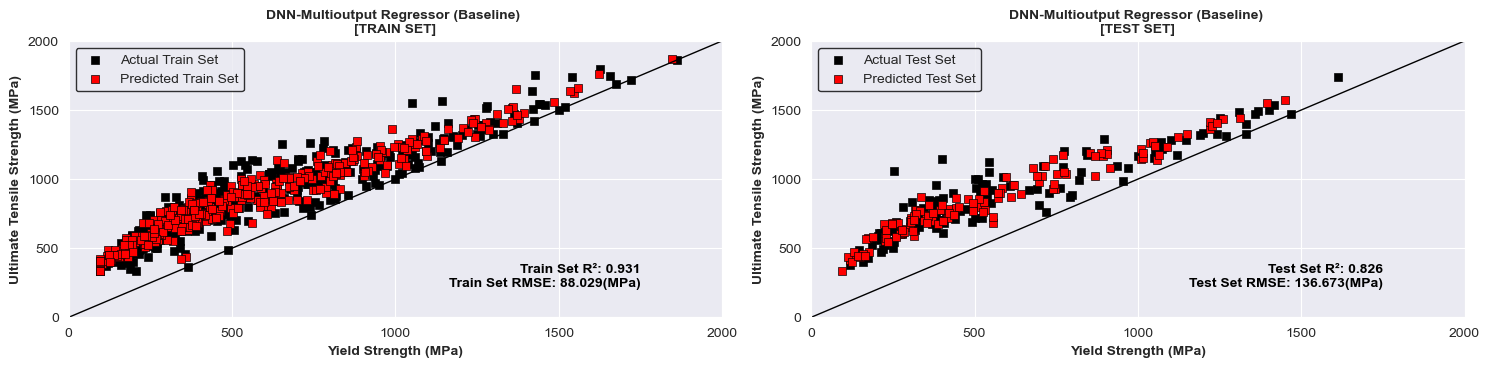

In [ ]:
plt.figure(figsize = (15, 10))
sns.set_style("darkgrid")
# plot for train set 
plt.subplot(3, 2, 1)
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Actual UTS (MPa)", 
                data = dnn_bl_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", label = "Actual Train Set")
sns.scatterplot(x = "Predicted YS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_bl_ed_train_df,
                marker = "s",
                color = "red",
                edgecolor = "black", label = "Predicted Train Set")
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
# annotation for test set R-squared and RMSE 
annotation_text = "Train Set R²: " + str(dnn_bl_ed_train_r2_ys_uts) + "\nTrain Set RMSE: " + str(dnn_bl_ed_train_rmse_ys_uts) + "(MPa)"
plt.text(1750, 200, annotation_text, ha = "right", va = "bottom", color = "black", fontsize = 10, fontweight = "bold")
plt.title("DNN-Multioutput Regressor (Baseline) \n[TRAIN SET]", fontsize = 10, fontweight = "bold")
plt.xlabel("Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

# plot for test set 
plt.subplot(3, 2, 2)
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Actual UTS (MPa)", 
                data = dnn_bl_ed_test_df,
                marker = "s",
                color = "black",
                edgecolor = "black", label = "Actual Test Set")
sns.scatterplot(x = "Predicted YS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_bl_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", label = "Predicted Test Set")
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
# annotation for test set R-squared and RMSE 
annotation_text = "Test Set R²: " + str(dnn_bl_ed_test_r2_ys_uts) + "\nTest Set RMSE: " + str(dnn_bl_ed_test_rmse_ys_uts) + "(MPa)"
plt.text(1750, 200, annotation_text, ha = "right", va = "bottom", color = "black", fontsize = 10, fontweight = "bold")
plt.title("DNN-Multioutput Regressor (Baseline) \n[TEST SET]", fontsize = 10, fontweight = "bold")
plt.xlabel("Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

plt.tight_layout()
plt.show()

##### **Comparison Plot of YS, UTS, and EL**

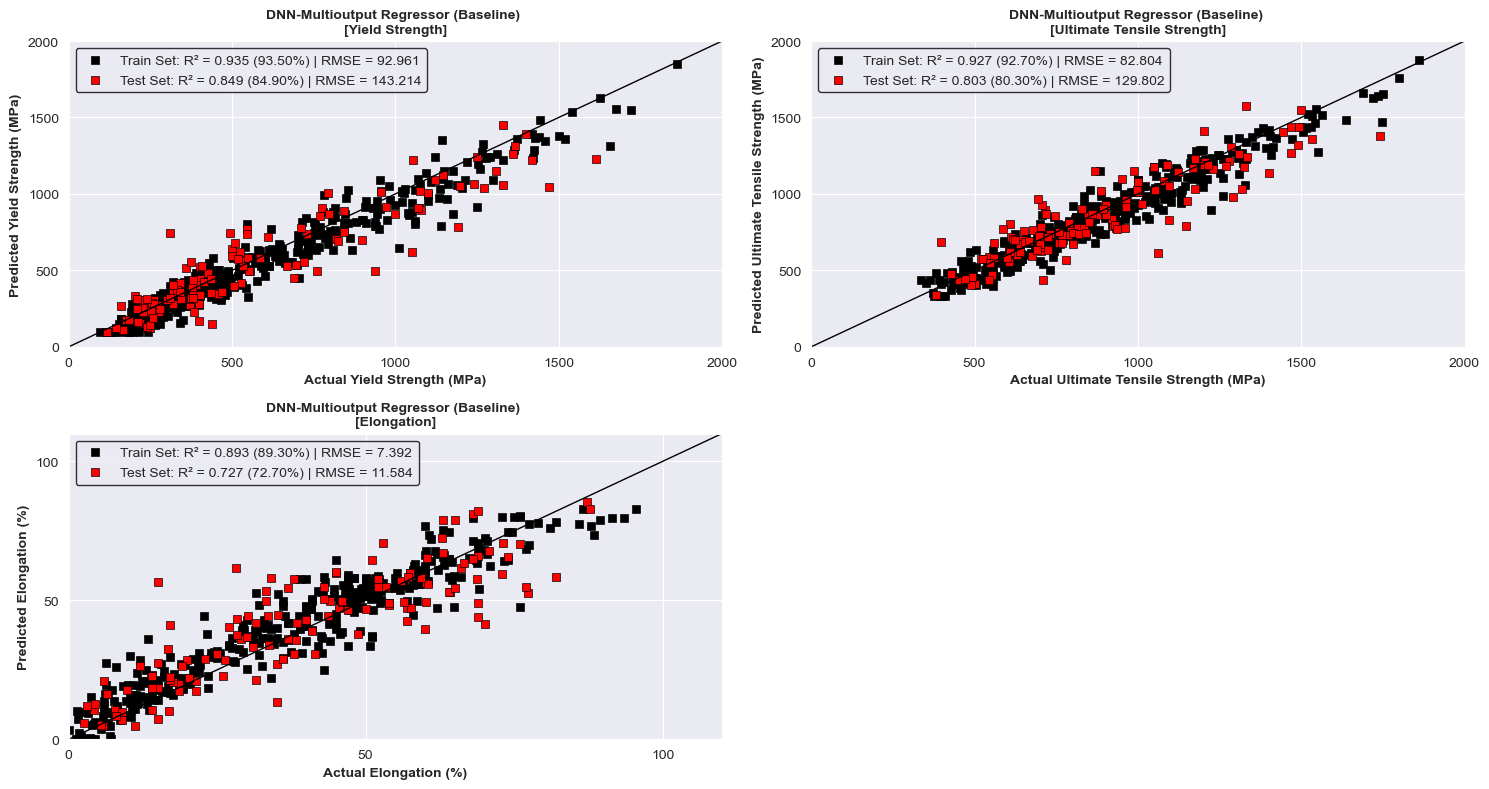

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (15, 8))

# plot for YS 
plt.subplot(2, 2, 1)
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Predicted YS (MPa)", 
                data = dnn_bl_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_train_r2_ys, dnn_bl_ed_train_r2_ys*100, dnn_bl_ed_train_rmse_ys))
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Predicted YS (MPa)", 
                data = dnn_bl_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_test_r2_ys, dnn_bl_ed_test_r2_ys*100, dnn_bl_ed_test_rmse_ys))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Baseline) \n[Yield Strength]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

# plot for UTS
plt.subplot(2, 2, 2)
sns.scatterplot(x = "Actual UTS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_bl_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_train_r2_uts, dnn_bl_ed_train_r2_uts*100, dnn_bl_ed_train_rmse_uts))
sns.scatterplot(x = "Actual UTS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_bl_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_test_r2_uts, dnn_bl_ed_test_r2_uts*100, dnn_bl_ed_test_rmse_uts))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Baseline) \n[Ultimate Tensile Strength]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

# plot for EL
plt.subplot(2, 2, 3)
sns.scatterplot(x = "Actual EL (%)", 
                y = "Predicted EL (%)", 
                data = dnn_bl_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_train_r2_el, dnn_bl_ed_train_r2_el*100, dnn_bl_ed_train_rmse_el))
sns.scatterplot(x = "Actual EL (%)", 
                y = "Predicted EL (%)", 
                data = dnn_bl_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_bl_ed_test_r2_el, dnn_bl_ed_test_r2_el*100, dnn_bl_ed_test_rmse_el))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 110], y = [0, 110], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Baseline) \n[Elongation]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Elongation (%)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Elongation (%)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 110)
plt.ylim(0, 110)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 110, 50))
plt.yticks(np.arange(0, 110, 50))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

plt.tight_layout()
plt.show()

### **(B) Hyperparameter Optimization - Grid-Search CV**

In [ ]:
def dnn_mo():
    dnn_mo_model = Sequential()
    dnn_mo_model.add(Dense(64, kernel_initializer = "LecunUniform", kernel_regularizer = l2(0.000001), input_dim = 26, activation = "gelu"))
    dnn_mo_model.add(Dropout(0.1))
    dnn_mo_model.add(Dense(32, kernel_initializer = "LecunUniform", kernel_regularizer = l2(0.000001), activation = "gelu"))
    dnn_mo_model.add(Dropout(0.1))
    dnn_mo_model.add(Dense(16, kernel_initializer = "LecunUniform", kernel_regularizer = l2(0.000001), activation = "gelu"))
    dnn_mo_model.add(Dropout(0.1))
    dnn_mo_model.add(Dense(3, activation = "relu"))
    return dnn_mo_model

In [ ]:
# calculate the start time 
start_time = time.time()

# initialize the best R2 scores
best_score = 0

# loop through different hyperparameter combinations 
for learningRate in [0.01, 0.02, 0.03, 0.04, 0.05]:
    for epochs in [250, 300, 350]:
            # initialize lists to store validation scores for each target variables and for each fold 
            dnn_gs1_ed_cv_val_r2Scores_ys_data = list() 
            dnn_gs1_ed_cv_val_r2Scores_uts_data = list()
            dnn_gs1_ed_cv_val_r2Scores_el_data = list() 
            
            # initialize the KFold cross-validator 
            kf_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
            
            i = 0
            with tf.device("/CPU"):
                # iterate through each fold 
                for train_index, val_index in kf_cv.split(X_train_ed):
                    # split the data into training and validation sets for the current fold 
                    X_train_cv, X_val_cv = X_train_ed.iloc[train_index], X_train_ed.iloc[val_index]
                    y_train_cv, y_val_cv = y_train_ed.iloc[train_index], y_train_ed.iloc[val_index]
                    
                    i+=1
                    # define base model 
                    dnn_mo_gs = KerasRegressor(model = dnn_mo, 
                                                loss = custom_mse_loss, 
                                                batch_size = 32, 
                                                epochs = epochs, 
                                                optimizer = Adamax(learning_rate = learningRate),
                                                metrics = [R2Score, RootMeanSquaredError],
                                                random_state = 42)
                    
                    # fit the model on training data
                    dnn_mo_gs.fit(X_train_cv, y_train_cv, shuffle = True)

                    # predictions on validation data
                    dnn_gs1_ed_cv_val_predict = dnn_mo_gs.predict(X_val_cv)
                
                    # compute validation R2 scores for yield_strength 
                    dnn_gs1_ed_cv_val_r2Scores_ys = r2_score(y_val_cv['yield_strength'], dnn_gs1_ed_cv_val_predict[:, 0])
                    # append scores to respective lists for yield strength
                    dnn_gs1_ed_cv_val_r2Scores_ys_data.append(dnn_gs1_ed_cv_val_r2Scores_ys)

                    # compute validation R2 scores for ultimate tensile strength 
                    dnn_gs1_ed_cv_val_r2Scores_uts = r2_score(y_val_cv['ultimate_tensile_strength'], dnn_gs1_ed_cv_val_predict[:, 1])
                    # append scores to respective lists for ultimate tensile strength
                    dnn_gs1_ed_cv_val_r2Scores_uts_data.append(dnn_gs1_ed_cv_val_r2Scores_uts)
                    
                    # compute validation R2 scoresfor elongation
                    dnn_gs1_ed_cv_val_r2Scores_el = r2_score(y_val_cv['elongation'], dnn_gs1_ed_cv_val_predict[:, 2])
                    # append scores to respective lists for elongation
                    dnn_gs1_ed_cv_val_r2Scores_el_data.append(dnn_gs1_ed_cv_val_r2Scores_el)

                    # compute the mean of the validation R2 scores across the target variables for each fold
                    cv_val_avg_scores = np.mean([dnn_gs1_ed_cv_val_r2Scores_ys, dnn_gs1_ed_cv_val_r2Scores_uts, dnn_gs1_ed_cv_val_r2Scores_el])
                    # display each combination of parameters
                    print("[CV {}/5]: learning_rate = {}, epochs = {} (Validation Score: {:.4f})".format(i, learningRate, epochs, cv_val_avg_scores))
            
            # compute the mean of the validation R2 scores for YS for each combination 
            dnn_gs1_ed_mean_cv_val_r2Scores_ys = np.mean(dnn_gs1_ed_cv_val_r2Scores_ys_data)

            # compute the mean of the validation R2 scores for UTS for each combination
            dnn_gs1_ed_mean_cv_val_r2Scores_uts = np.mean(dnn_gs1_ed_cv_val_r2Scores_uts_data)

            # compute the mean of the validation R2 scores for EL for each combination
            dnn_gs1_ed_mean_cv_val_r2Scores_el = np.mean(dnn_gs1_ed_cv_val_r2Scores_el_data)
            
            # compute the mean of the validation R2 scores across the target variables for each combination 
            dnn_gs1_ed_avg_scores = np.mean([dnn_gs1_ed_mean_cv_val_r2Scores_ys, dnn_gs1_ed_mean_cv_val_r2Scores_uts, dnn_gs1_ed_mean_cv_val_r2Scores_el])
            
            # if we got a better R-squared validation score, store the score and parameters 
            if dnn_gs1_ed_avg_scores > best_score:
                best_score = dnn_gs1_ed_avg_scores
                best_parameters = {"learning_rate": learningRate, 
                                    "epochs": epochs}

# calculate the end time
end_time = time.time()

Epoch 1/250
10/10 [==============================] - 1s 2ms/step - loss: 0.1190 - r2_score: -1.5694 - root_mean_squared_error: 0.3404
Epoch 2/250
10/10 [==============================] - 0s 897us/step - loss: 0.0832 - r2_score: -0.8566 - root_mean_squared_error: 0.2874
Epoch 3/250
10/10 [==============================] - 0s 1ms/step - loss: 0.0668 - r2_score: -0.4852 - root_mean_squared_error: 0.2570
Epoch 4/250
10/10 [==============================] - 0s 1ms/step - loss: 0.0509 - r2_score: -0.1067 - root_mean_squared_error: 0.2225
Epoch 5/250
10/10 [==============================] - 0s 797us/step - loss: 0.0428 - r2_score: 0.0744 - root_mean_squared_error: 0.2041
Epoch 6/250
10/10 [==============================] - 0s 1ms/step - loss: 0.0340 - r2_score: 0.2702 - root_mean_squared_error: 0.1825
Epoch 7/250
10/10 [==============================] - 0s 1ms/step - loss: 0.0315 - r2_score: 0.3258 - root_mean_squared_error: 0.1759
Epoch 8/250
10/10 [==============================] - 0s 916us

In [ ]:
# calculate the total time taken 
time_taken = end_time - start_time 
print("Time Taken: ", time_taken, "seconds")

Time Taken:  340.70001006126404 seconds


In [ ]:
# display the best score and best parameters
print("The best overall R2 score is: {:.4f}".format(best_score))
print("The optimal hyperparameters is: {}".format(best_parameters))

The best overall R2 score is: 0.7443
The optimal hyperparameters is: {'learning_rate': 0.01, 'epochs': 300}


### **(C) Validate Optimized Model with Optimized Hyperparameters**

In [351]:
def dnn_gs_mo():
    dnn_mo = Sequential()
    dnn_mo.add(Dense(64, kernel_initializer = "LecunUniform", input_dim = 26, kernel_regularizer = l2(0.000001), activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(32, kernel_initializer = "LecunUniform", kernel_regularizer = l2(0.000001), activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(16, kernel_initializer = "LecunUniform", kernel_regularizer = l2(0.000001), activation = "gelu"))
    dnn_mo.add(Dropout(0.1))
    dnn_mo.add(Dense(3, activation = "relu"))
    return dnn_mo

#### **K-Fold Cross-Validation Approach**

In [ ]:
def kFold_crossValidator(nSplits):
    # initialize lists to store train and validation scores for each target variables and for each fold 
    dnn_gs_ed_cv_train_r2Scores_ys_data = list() 
    dnn_gs_ed_cv_train_r2Scores_uts_data = list()
    dnn_gs_ed_cv_train_r2Scores_el_data = list() 
    dnn_gs_ed_cv_val_r2Scores_ys_data = list() 
    dnn_gs_ed_cv_val_r2Scores_uts_data = list()
    dnn_gs_ed_cv_val_r2Scores_el_data = list() 

    dnn_gs_ed_cv_train_rmse_ys_data = list()
    dnn_gs_ed_cv_train_rmse_uts_data = list()
    dnn_gs_ed_cv_train_rmse_el_data = list()
    dnn_gs_ed_cv_val_rmse_ys_data = list()
    dnn_gs_ed_cv_val_rmse_uts_data = list()
    dnn_gs_ed_cv_val_rmse_el_data = list()

    ymin = tf.reduce_min(y_train_ed)
    ymax = tf.reduce_max(y_train_ed)

    # initialize the KFold cross-validator 
    kf_cv = KFold(n_splits = nSplits, shuffle = True, random_state = 42)
    # iterate through each fold 
    for train_index, val_index in kf_cv.split(X_train_ed):
        min_max_scaler = MinMaxScaler()
        # scaling the train target features using the fit_transform method with the selected target columns
        y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.fit_transform(y_train_original[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
        
        # split the data into training and validation sets for the current fold 
        X_train_gs_cv, X_val_gs_cv = X_train_ed.iloc[train_index], X_train_ed.iloc[val_index]
        y_train_gs_cv, y_val_gs_cv = y_train_ed.iloc[train_index], y_train_ed.iloc[val_index]
        

        with tf.device("/CPU"):
            # define base model 
            dnn_gs_ed_cv = KerasRegressor(model = dnn_gs_mo, 
                                        loss = custom_mse_loss, 
                                        batch_size = 32, 
                                        epochs = 300, 
                                        optimizer = Adamax(learning_rate = 0.01),
                                        metrics = [R2Score, RootMeanSquaredError],
                                        random_state = 42)

            # fit the model on training data
            dnn_gs_ed_cv.fit(X_train_gs_cv, y_train_gs_cv, shuffle = True)

            # predictions on training and validation data
            dnn_gs_ed_cv_train_predict = dnn_gs_ed_cv.predict(X_train_gs_cv)
            dnn_gs_ed_cv_val_predict = dnn_gs_ed_cv.predict(X_val_gs_cv)

            # convert to its original scale
            y_train_gs_cv = min_max_scaler.inverse_transform(y_train_gs_cv)
            y_val_gs_cv = min_max_scaler.inverse_transform(y_val_gs_cv)
            dnn_gs_ed_cv_train_predict = min_max_scaler.inverse_transform(dnn_gs_ed_cv_train_predict)
            dnn_gs_ed_cv_val_predict = min_max_scaler.inverse_transform(dnn_gs_ed_cv_val_predict)
            
            # compute train scores (R2 and RMSE) for yield_strength 
            dnn_gs_ed_cv_train_r2Scores_ys = r2_score(y_train_gs_cv[:, 0], dnn_gs_ed_cv_train_predict[:, 0])
            dnn_gs_ed_cv_train_rmse_ys = np.sqrt(mean_squared_error(y_train_gs_cv[:, 0], dnn_gs_ed_cv_train_predict[:, 0]))
            # append scores to respective lists for yield strength
            dnn_gs_ed_cv_train_r2Scores_ys_data.append(dnn_gs_ed_cv_train_r2Scores_ys)
            dnn_gs_ed_cv_train_rmse_ys_data.append(dnn_gs_ed_cv_train_rmse_ys)

            # compute validation scores (R2 and RMSE) for yield_strength 
            dnn_gs_ed_cv_val_r2Scores_ys = r2_score(y_val_gs_cv[:, 0], dnn_gs_ed_cv_val_predict[:, 0])
            dnn_gs_ed_cv_val_rmse_ys = np.sqrt(mean_squared_error(y_val_gs_cv[:, 0], dnn_gs_ed_cv_val_predict[:, 0]))
            # append scores to respective lists for yield strength
            dnn_gs_ed_cv_val_r2Scores_ys_data.append(dnn_gs_ed_cv_val_r2Scores_ys)
            dnn_gs_ed_cv_val_rmse_ys_data.append(dnn_gs_ed_cv_val_rmse_ys)

            # compute train scores (R2 and RMSE) for ultimate tensile strength 
            dnn_gs_ed_cv_train_r2Scores_uts = r2_score(y_train_gs_cv[:, 1], dnn_gs_ed_cv_train_predict[:, 1])
            dnn_gs_ed_cv_train_rmse_uts = np.sqrt(mean_squared_error(y_train_gs_cv[:, 1], dnn_gs_ed_cv_train_predict[:, 1]))
            # append scores to respective lists for ultimate tensile strength
            dnn_gs_ed_cv_train_r2Scores_uts_data.append(dnn_gs_ed_cv_train_r2Scores_uts)
            dnn_gs_ed_cv_train_rmse_uts_data.append(dnn_gs_ed_cv_train_rmse_uts)

            # compute validation scores (R2 and RMSE) for ultimate tensile strength 
            dnn_gs_ed_cv_val_r2Scores_uts = r2_score(y_val_gs_cv[:, 1], dnn_gs_ed_cv_val_predict[:, 1])
            dnn_gs_ed_cv_val_rmse_uts = np.sqrt(mean_squared_error(y_val_gs_cv[:, 1], dnn_gs_ed_cv_val_predict[:, 1]))
            # append scores to respective lists for ultimate tensile strength
            dnn_gs_ed_cv_val_r2Scores_uts_data.append(dnn_gs_ed_cv_val_r2Scores_uts)
            dnn_gs_ed_cv_val_rmse_uts_data.append(dnn_gs_ed_cv_val_rmse_uts)

            # compute train scores (R2 and RMSE) for elongation 
            dnn_gs_ed_cv_train_r2Scores_el = r2_score(y_train_gs_cv[:, 2], dnn_gs_ed_cv_train_predict[:, 2])
            dnn_gs_ed_cv_train_rmse_el = np.sqrt(mean_squared_error(y_train_gs_cv[:, 2], dnn_gs_ed_cv_train_predict[:, 2]))
            # append scores to respective lists for elongation
            dnn_gs_ed_cv_train_r2Scores_el_data.append(dnn_gs_ed_cv_train_r2Scores_el)
            dnn_gs_ed_cv_train_rmse_el_data.append(dnn_gs_ed_cv_train_rmse_el)

            # compute validation scores (R2 and RMSE) for elongation
            dnn_gs_ed_cv_val_r2Scores_el = r2_score(y_val_gs_cv[:, 2], dnn_gs_ed_cv_val_predict[:, 2])
            dnn_gs_ed_cv_val_rmse_el = np.sqrt(mean_squared_error(y_val_gs_cv[:, 2], dnn_gs_ed_cv_val_predict[:, 2]))
            # append scores to respective lists for elongation
            dnn_gs_ed_cv_val_r2Scores_el_data.append(dnn_gs_ed_cv_val_r2Scores_el)
            dnn_gs_ed_cv_val_rmse_el_data.append(dnn_gs_ed_cv_val_rmse_el)
            
    # tabulate the results 
    # display the cross validation scores of the r-squared and rmse for all mechanical properties
    overall_results = pd.DataFrame({'Mechanical Properties': ['YS', 
                                                            'YS', 
                                                            'UTS', 
                                                            'UTS', 
                                                            'EL', 
                                                            'EL'],
                                    'R2 Score': [np.mean(dnn_gs_ed_cv_train_r2Scores_ys_data), 
                                                np.mean(dnn_gs_ed_cv_val_r2Scores_ys_data), 
                                                np.mean(dnn_gs_ed_cv_train_r2Scores_uts_data), 
                                                np.mean(dnn_gs_ed_cv_val_r2Scores_uts_data), 
                                                np.mean(dnn_gs_ed_cv_train_r2Scores_el_data), 
                                                np.mean(dnn_gs_ed_cv_val_r2Scores_el_data)],  
                                    'RMSE': [np.mean(dnn_gs_ed_cv_train_rmse_ys_data), 
                                            np.mean(dnn_gs_ed_cv_val_rmse_ys_data), 
                                            np.mean(dnn_gs_ed_cv_train_rmse_uts_data), 
                                            np.mean(dnn_gs_ed_cv_val_rmse_uts_data), 
                                            np.mean(dnn_gs_ed_cv_train_rmse_el_data), 
                                            np.mean(dnn_gs_ed_cv_val_rmse_el_data)]})
    overall_results.rename(index = {0: 'Train', 1: 'Validation', 2: 'Train', 3: 'Validation', 4: 'Train', 5: 'Validation'}, inplace = True)

    return overall_results


In [ ]:
# # call the function to display the cross validation results (k-fold = 5)
kfold_5 = kFold_crossValidator(5)

Epoch 1/300
10/10 [==============================] - 0s 1ms/step - loss: 0.1190 - r2_score: -1.5694 - root_mean_squared_error: 0.3404
Epoch 2/300
10/10 [==============================] - 0s 999us/step - loss: 0.0832 - r2_score: -0.8566 - root_mean_squared_error: 0.2874
Epoch 3/300
10/10 [==============================] - 0s 885us/step - loss: 0.0668 - r2_score: -0.4852 - root_mean_squared_error: 0.2570
Epoch 4/300
10/10 [==============================] - 0s 818us/step - loss: 0.0509 - r2_score: -0.1067 - root_mean_squared_error: 0.2225
Epoch 5/300
10/10 [==============================] - 0s 982us/step - loss: 0.0428 - r2_score: 0.0744 - root_mean_squared_error: 0.2041
Epoch 6/300
10/10 [==============================] - 0s 877us/step - loss: 0.0340 - r2_score: 0.2702 - root_mean_squared_error: 0.1825
Epoch 7/300
10/10 [==============================] - 0s 806us/step - loss: 0.0315 - r2_score: 0.3258 - root_mean_squared_error: 0.1759
Epoch 8/300
10/10 [==============================] - 

In [ ]:
# display the results for k-fold = 5
print("K-Fold Cross-Validation: 5")
kfold_5

K-Fold Cross-Validation: 5


Mechanical Properties  R2 Score        RMSE
Train                         YS  0.951607   80.376094
Validation                    YS  0.813653  155.181223
Train                        UTS  0.939620   75.243335
Validation                   UTS  0.754177  150.507392
Train                         EL  0.908933    6.800731
Validation                    EL  0.664981   12.979568

In [ ]:
# call the function to display the cross validation overall results (k-fold = 10)
kfold_10 = kFold_crossValidator(10)

Epoch 1/300
11/11 [==============================] - 0s 1ms/step - loss: 0.1030 - r2_score: -1.2154 - root_mean_squared_error: 0.3176
Epoch 2/300
11/11 [==============================] - 0s 938us/step - loss: 0.0695 - r2_score: -0.5301 - root_mean_squared_error: 0.2624
Epoch 3/300
11/11 [==============================] - 0s 915us/step - loss: 0.0507 - r2_score: -0.1117 - root_mean_squared_error: 0.2241
Epoch 4/300
11/11 [==============================] - 0s 885us/step - loss: 0.0395 - r2_score: 0.1630 - root_mean_squared_error: 0.1959
Epoch 5/300
11/11 [==============================] - 0s 803us/step - loss: 0.0311 - r2_score: 0.3379 - root_mean_squared_error: 0.1752
Epoch 6/300
11/11 [==============================] - 0s 943us/step - loss: 0.0322 - r2_score: 0.3148 - root_mean_squared_error: 0.1783
Epoch 7/300
11/11 [==============================] - 0s 913us/step - loss: 0.0270 - r2_score: 0.4259 - root_mean_squared_error: 0.1633
Epoch 8/300
11/11 [==============================] - 0

In [ ]:
# display the results for k-fold = 10
print("K-Fold Cross-Validation: 10")
kfold_10

K-Fold Cross-Validation: 10


Mechanical Properties  R2 Score        RMSE
Train                         YS  0.951879   80.112136
Validation                    YS  0.783444  163.724979
Train                        UTS  0.940738   74.484597
Validation                   UTS  0.752478  147.786043
Train                         EL  0.913418    6.630544
Validation                    EL  0.659653   12.691710

In [ ]:
# call the function to display the cross validation overall results (k-fold = 20)
kfold_20 = kFold_crossValidator(20)

Epoch 1/300
12/12 [==============================] - 0s 1ms/step - loss: 0.1013 - r2_score: -1.1496 - root_mean_squared_error: 0.3127
Epoch 2/300
12/12 [==============================] - 0s 845us/step - loss: 0.0676 - r2_score: -0.4617 - root_mean_squared_error: 0.2576
Epoch 3/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0535 - r2_score: -0.1397 - root_mean_squared_error: 0.2287
Epoch 4/300
12/12 [==============================] - 0s 862us/step - loss: 0.0417 - r2_score: 0.1112 - root_mean_squared_error: 0.2017
Epoch 5/300
12/12 [==============================] - 0s 916us/step - loss: 0.0350 - r2_score: 0.2533 - root_mean_squared_error: 0.1856
Epoch 6/300
12/12 [==============================] - 0s 772us/step - loss: 0.0314 - r2_score: 0.3342 - root_mean_squared_error: 0.1761
Epoch 7/300
12/12 [==============================] - 0s 832us/step - loss: 0.0314 - r2_score: 0.3362 - root_mean_squared_error: 0.1758
Epoch 8/300
12/12 [==============================] - 0s 

In [ ]:
# display the results for k-fold = 20
print("K-Fold Cross-Validation: 20")
kfold_20

K-Fold Cross-Validation: 20


Mechanical Properties  R2 Score        RMSE
Train                         YS  0.937532   91.257296
Validation                    YS  0.760097  154.415178
Train                        UTS  0.921922   85.486155
Validation                   UTS  0.723921  145.068206
Train                         EL  0.877414    7.886965
Validation                    EL  0.618728   12.997964

#### **Hold-Out Validation Approach**

In [352]:
# training set for training
with tf.device("/CPU"):
    # define base model
    dnn_gs_ed = KerasRegressor(model = dnn_gs_mo, 
                                loss = custom_mse_loss, 
                                batch_size = 32, 
                                epochs = 300, 
                                optimizer = Adamax(learning_rate = 0.01),
                                metrics = [R2Score, RootMeanSquaredError],
                                random_state = 42)
    # fit the DNN regressor to the training data
    dnn_gs_ed.fit(X_train_ed, y_train_ed, shuffle = True)

Epoch 1/300
12/12 [==============================] - 1s 2ms/step - loss: 0.1181 - r2_score: -1.5108 - root_mean_squared_error: 0.3390
Epoch 2/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0767 - r2_score: -0.6901 - root_mean_squared_error: 0.2765
Epoch 3/300
12/12 [==============================] - 0s 830us/step - loss: 0.0576 - r2_score: -0.2515 - root_mean_squared_error: 0.2377
Epoch 4/300
12/12 [==============================] - 0s 806us/step - loss: 0.0391 - r2_score: 0.1625 - root_mean_squared_error: 0.1957
Epoch 5/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0330 - r2_score: 0.3025 - root_mean_squared_error: 0.1803
Epoch 6/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0324 - r2_score: 0.3087 - root_mean_squared_error: 0.1789
Epoch 7/300
12/12 [==============================] - 0s 832us/step - loss: 0.0314 - r2_score: 0.3297 - root_mean_squared_error: 0.1761
Epoch 8/300
12/12 [==============================] - 0s 895u

12/12 [==============================] - 0s 2ms/step


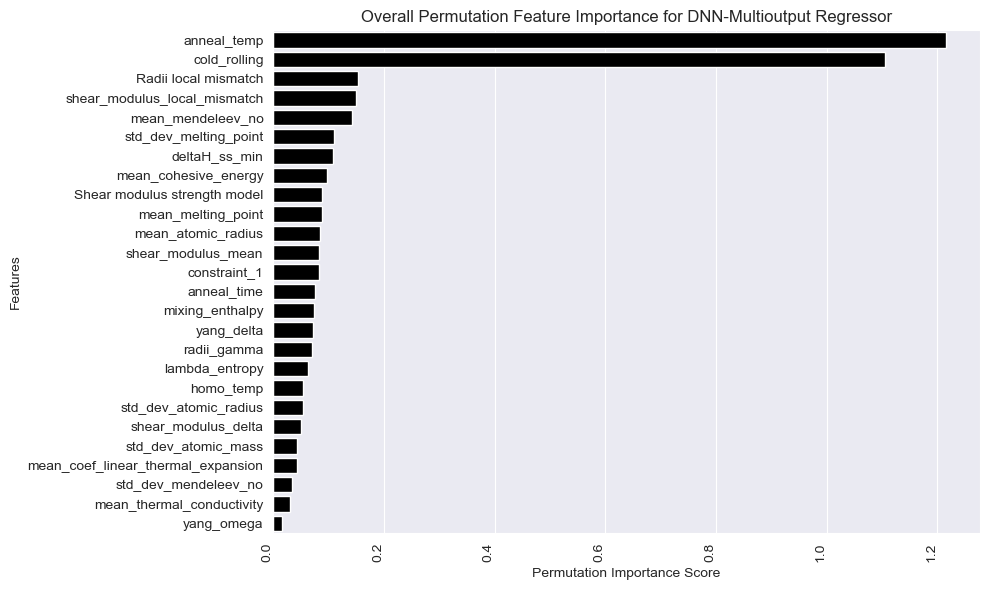

In [ ]:
# compute the permutation feature importances 
permutation_importance(dnn_gs_ed, X_train_ed, y_train_ed, 10)

In [353]:
# use the trained DNN regressor to predict both YS, UTS, and EL on the training set
dnn_gs_ed_train_predict = dnn_gs_ed.predict(X_train_ed)
# use the trained DNN regressor to predict both YS, UTS, and EL on the testing set
dnn_gs_ed_test_predict = dnn_gs_ed.predict(X_test_ed)

# inverse transforming scaled back to original scale for training and testing set
y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.inverse_transform(y_train_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']] = min_max_scaler.inverse_transform(y_test_ed[['yield_strength', 'ultimate_tensile_strength', 'elongation']])
# inverse transforming scaled prediction back to original scale 
dnn_gs_ed_train_predict = min_max_scaler.inverse_transform(dnn_gs_ed_train_predict)
dnn_gs_ed_test_predict = min_max_scaler.inverse_transform(dnn_gs_ed_test_predict)

4/4 [==============================] - 0s 24ms/step


**Validation Outcome for YS+UTS**

In [354]:
# outcome of ultimate tensile strength and yield strength
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_r2_ys_uts = round(r2_score(y_train_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_gs_ed_train_predict[:, [0, 1]]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_rmse_ys_uts = round(np.sqrt(mean_squared_error(y_train_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_gs_ed_train_predict[:, [0, 1]])), 3)
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_r2_ys_uts = round(r2_score(y_test_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_gs_ed_test_predict[:, [0, 1]]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_rmse_ys_uts = round(np.sqrt(mean_squared_error(y_test_ed[['yield_strength', 'ultimate_tensile_strength']], dnn_gs_ed_test_predict[:, [0, 1]])), 3)
# display the results
dnn_gs_ed_traintest_res_ys_uts = pd.DataFrame({'R2 Score': [dnn_gs_ed_train_r2_ys_uts, dnn_gs_ed_test_r2_ys_uts], 
                              'RMSE (MPa)': [dnn_gs_ed_train_rmse_ys_uts, dnn_gs_ed_test_rmse_ys_uts]})
dnn_gs_ed_traintest_res_ys_uts.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_gs_ed_traintest_res_ys_uts

R2 Score  RMSE (MPa)
Train     0.944      80.035
Test      0.847     128.215

**Validation Outcome for YS**

In [355]:
# outcome of yield strength
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_r2_ys = round(r2_score(y_train_ed['yield_strength'], dnn_gs_ed_train_predict[:, 0]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_rmse_ys = round(np.sqrt(mean_squared_error(y_train_ed['yield_strength'], dnn_gs_ed_train_predict[:, 0])), 3)
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_r2_ys = round(r2_score(y_test_ed['yield_strength'], dnn_gs_ed_test_predict[:, 0]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_rmse_ys = round(np.sqrt(mean_squared_error(y_test_ed['yield_strength'], dnn_gs_ed_test_predict[:, 0])), 3)
# display the results
dnn_gs_ed_traintest_res_ys = pd.DataFrame({'R2 Score': [dnn_gs_ed_train_r2_ys, dnn_gs_ed_test_r2_ys], 
                              'RMSE (MPa)': [dnn_gs_ed_train_rmse_ys, dnn_gs_ed_test_rmse_ys]})
dnn_gs_ed_traintest_res_ys.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_gs_ed_traintest_res_ys

R2 Score  RMSE (MPa)
Train     0.944      86.309
Test      0.866     134.621

**Validation Outcome for UTS**

In [356]:
# outcome of ultimate tensile strength
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_r2_uts = round(r2_score(y_train_ed['ultimate_tensile_strength'], dnn_gs_ed_train_predict[:, 1]), 3)
# compute the rmse score for the DNN regressorwith optimized hyperparameters on the train set
dnn_gs_ed_train_rmse_uts = round(np.sqrt(mean_squared_error(y_train_ed['ultimate_tensile_strength'], dnn_gs_ed_train_predict[:, 1])), 3)
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_r2_uts = round(r2_score(y_test_ed['ultimate_tensile_strength'], dnn_gs_ed_test_predict[:, 1]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_rmse_uts = round(np.sqrt(mean_squared_error(y_test_ed['ultimate_tensile_strength'], dnn_gs_ed_test_predict[:, 1])), 3)
# display the results
dnn_gs_ed_traintest_res_uts = pd.DataFrame({'R2 Score': [dnn_gs_ed_train_r2_uts, dnn_gs_ed_test_r2_uts], 
                              'RMSE (%)': [dnn_gs_ed_train_rmse_uts, dnn_gs_ed_test_rmse_uts]})
dnn_gs_ed_traintest_res_uts.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_gs_ed_traintest_res_uts

R2 Score  RMSE (%)
Train     0.943    73.225
Test      0.827   121.473

**Validation Outcome for EL**

In [357]:
# outcome of elongation
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_r2_el = round(r2_score(y_train_ed['elongation'], dnn_gs_ed_train_predict[:, 2]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the train set
dnn_gs_ed_train_rmse_el = round(np.sqrt(mean_squared_error(y_train_ed['elongation'], dnn_gs_ed_train_predict[:, 2])), 3)
# compute the r-squared score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_r2_el = round(r2_score(y_test_ed['elongation'], dnn_gs_ed_test_predict[:, 2]), 3)
# compute the rmse score for the DNN regressor with optimized hyperparameters on the test set
dnn_gs_ed_test_rmse_el = round(np.sqrt(mean_squared_error(y_test_ed['elongation'], dnn_gs_ed_test_predict[:, 2])), 3)
# display the results
dnn_gs_ed_traintest_res_el = pd.DataFrame({'R2 Score': [dnn_gs_ed_train_r2_el, dnn_gs_ed_test_r2_el], 
                              'RMSE (%)': [dnn_gs_ed_train_rmse_el, dnn_gs_ed_test_rmse_el]})
dnn_gs_ed_traintest_res_el.rename(index = {0: 'Train', 1: 'Test'}, inplace = True)
dnn_gs_ed_traintest_res_el

R2 Score  RMSE (%)
Train     0.910     6.780
Test      0.741    11.284

### **Learning Curve**

##### **Losses**

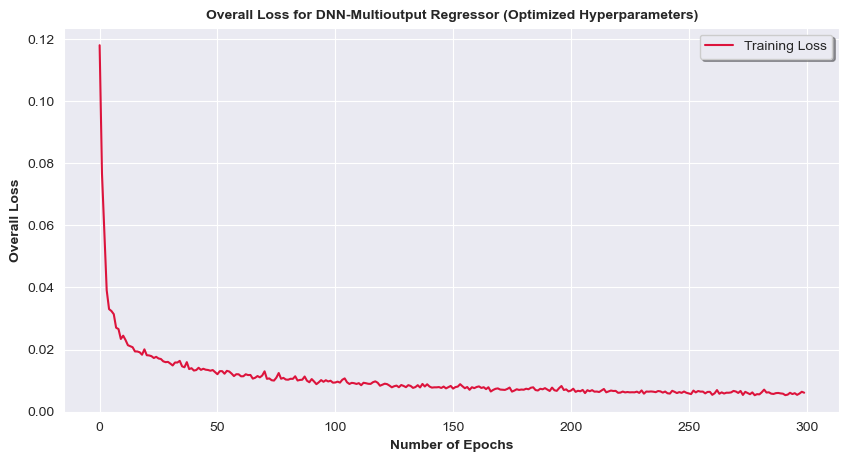

In [358]:
# summarize history for losses
sns.set_style("darkgrid")
#set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_gs_ed.history_['loss'], color = "crimson", label = "Training Loss")
# set title
plt.title("Overall Loss for DNN-Multioutput Regressor (Optimized Hyperparameters)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall Loss", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'upper right')
# show the plot
plt.show()

##### **RMSE**

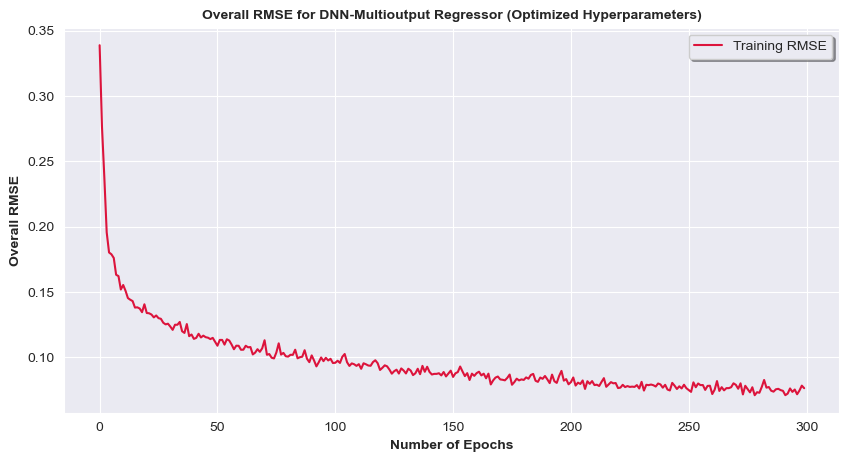

In [359]:
# summarize history for RMSE
sns.set_style("darkgrid")
#set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_gs_ed.history_['root_mean_squared_error'], color = "crimson", label = "Training RMSE")
# set title
plt.title("Overall RMSE for DNN-Multioutput Regressor (Optimized Hyperparameters)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall RMSE", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'upper right')
# show the plot
plt.show()

##### **R-Squared**

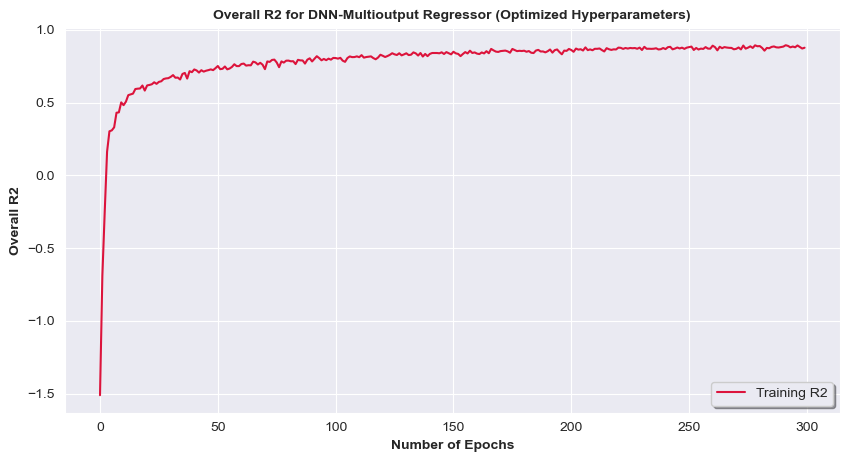

In [360]:
# summarize history for R-squared
sns.set_style("darkgrid")
# set figure size
plt.figure(figsize = (10, 5))
# plot training accuracy curve
sns.lineplot(data = dnn_gs_ed.history_['r2_score'], color = "crimson", label = "Training R2")
# set title
plt.title("Overall R2 for DNN-Multioutput Regressor (Optimized Hyperparameters)", fontweight = 'bold', fontsize = 10)
# set axis labels
plt.xlabel("Number of Epochs", fontweight = 'bold', fontsize = 10)
plt.ylabel("Overall R2", fontweight = 'bold', fontsize = 10)
# show legend
plt.legend(shadow = True, loc = 'lower right')
# show the plot
plt.show()

### **Comparison Plot on Optimized Model with Optimized Hyperparameters (Train Set and Test Set)**

In [361]:
# training set
# create a copy of the training set 
dnn_gs_ed_train_df = y_train_ed.copy()
# renaming the columns 
dnn_gs_ed_train_df.rename(columns = {'yield_strength': 'Actual YS (MPa)', 
                               'ultimate_tensile_strength': 'Actual UTS (MPa)', 
                               'elongation': 'Actual EL (%)'}, inplace = True)
# adding columns 
dnn_gs_ed_train_df[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = dnn_gs_ed_train_predict
# displaying the dataframe
dnn_gs_ed_train_df

Actual YS (MPa)  Actual UTS (MPa)  Actual EL (%)  Predicted YS (MPa)  \
234            625.0             855.0           50.7          618.452332   
348           1253.0            1392.0            8.2         1315.325195   
42             740.0             800.0           16.0          606.958618   
447            310.0             639.0           52.4          382.147705   
255           1625.0            1800.0            6.0         1606.380615   
..               ...               ...            ...                 ...   
403            430.0             768.0           67.4          372.692596   
329            465.0             912.0           70.5          474.191742   
413           1094.0            1205.0            9.6         1175.649414   
48             380.0             810.0           66.0          416.483643   
230            730.0             968.0           29.1          701.563110   

     Predicted UTS (MPa)  Predicted EL (%)  
234           833.179443         32.945339  
348          1455.528320          8.369005  
42            813.102600         28.182041  
447           680.947937         51.677876  
255          1724.168091          5.586452  
..                   ...               ...  
403           729.150513         69.891006  
329           963.244812         60.632908  
413          1294.452881          9.626018  
48            812.486328         55.628391  
230           955.807861         32.227924  

[373 rows x 6 columns]

In [362]:
# training set
# count the total number of respective mechanical properties that is negative values 
count_neg_val_ys_train_gs = dnn_gs_ed_train_df[dnn_gs_ed_train_df['Predicted YS (MPa)'] < 0]['Predicted YS (MPa)'].count()
count_neg_val_uts_train_gs = dnn_gs_ed_train_df[dnn_gs_ed_train_df['Predicted UTS (MPa)'] < 0]['Predicted UTS (MPa)'].count()
count_neg_val_el_train_gs = dnn_gs_ed_train_df[dnn_gs_ed_train_df['Predicted EL (%)'] < 0]['Predicted EL (%)'].count()
# create a new dataframe 
count_neg_val_train_gs = pd.DataFrame()
count_neg_val_train_gs[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = [[count_neg_val_ys_train_gs, count_neg_val_uts_train_gs, count_neg_val_el_train_gs]]
count_neg_val_train_gs

Predicted YS (MPa)  Predicted UTS (MPa)  Predicted EL (%)
0                   0                    0                 0

In [363]:
# training set
# count the total number of UTS is greater than the YS 
count_uts_gt_ys_train_gs = len(dnn_gs_ed_train_df[dnn_gs_ed_train_df['Predicted UTS (MPa)'] > dnn_gs_ed_train_df['Predicted YS (MPa)']])
count_uts_gt_ys_train_gs

373

In [364]:
# testing set
# create a copy of the testing set 
dnn_gs_ed_test_df = y_test_ed.copy()
# renaming the columns 
dnn_gs_ed_test_df.rename(columns = {'yield_strength': 'Actual YS (MPa)', 
                               'ultimate_tensile_strength': 'Actual UTS (MPa)', 
                               'elongation': 'Actual EL (%)'}, inplace = True)
# adding columns 
dnn_gs_ed_test_df[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = dnn_gs_ed_test_predict
# displaying the dataframe
dnn_gs_ed_test_df

Actual YS (MPa)  Actual UTS (MPa)  Actual EL (%)  Predicted YS (MPa)  \
362           1146.1            1284.3          18.60         1105.254761   
349           1400.0            1500.0           7.85         1495.695190   
309            545.0            1050.0          17.60          791.948547   
85             390.0             705.0          57.00          468.080078   
63             320.0             730.0          52.00          388.287659   
..               ...               ...            ...                 ...   
327            280.0             800.0          65.00          337.481476   
174            761.0             936.0          28.30          600.380127   
354           1050.0            1150.0          25.00          613.188843   
118           1250.0            1445.0           2.50         1113.182007   
361           1309.0            1489.1           9.80         1141.468018   

     Predicted UTS (MPa)  Predicted EL (%)  
362          1302.222290         23.694752  
349          1630.009644          3.867460  
309          1202.003174         15.432801  
85            846.405762         49.455254  
63            756.320374         44.283878  
..                   ...               ...  
327           730.631226         73.634010  
174           848.008789         32.999905  
354           964.836060         38.160427  
118          1282.651489          9.235769  
361          1326.708252         21.360943  

[125 rows x 6 columns]

In [365]:
# testing set
# count the total number of respective mechanical properties that is negative values 
count_neg_val_ys_test_gs = dnn_gs_ed_test_df[dnn_gs_ed_test_df['Predicted YS (MPa)'] < 0]['Predicted YS (MPa)'].count()
count_neg_val_uts_test_gs = dnn_gs_ed_test_df[dnn_gs_ed_test_df['Predicted UTS (MPa)'] < 0]['Predicted UTS (MPa)'].count()
count_neg_val_el_test_gs = dnn_gs_ed_test_df[dnn_gs_ed_test_df['Predicted EL (%)'] < 0]['Predicted EL (%)'].count()
# create a new dataframe 
count_neg_val_test_gs = pd.DataFrame()
count_neg_val_test_gs[['Predicted YS (MPa)', 'Predicted UTS (MPa)', 'Predicted EL (%)']] = [[count_neg_val_ys_test_gs, count_neg_val_uts_test_gs, count_neg_val_el_test_gs]]
count_neg_val_test_gs

Predicted YS (MPa)  Predicted UTS (MPa)  Predicted EL (%)
0                   0                    0                 0

In [366]:
# testing set
# count the total number of UTS is greater than the YS 
count_uts_gt_ys_test_gs = len(dnn_gs_ed_test_df[dnn_gs_ed_test_df['Predicted UTS (MPa)'] > dnn_gs_ed_test_df['Predicted YS (MPa)']])
count_uts_gt_ys_test_gs

125

##### **Comparison Plot of YS, UTS, and EL**

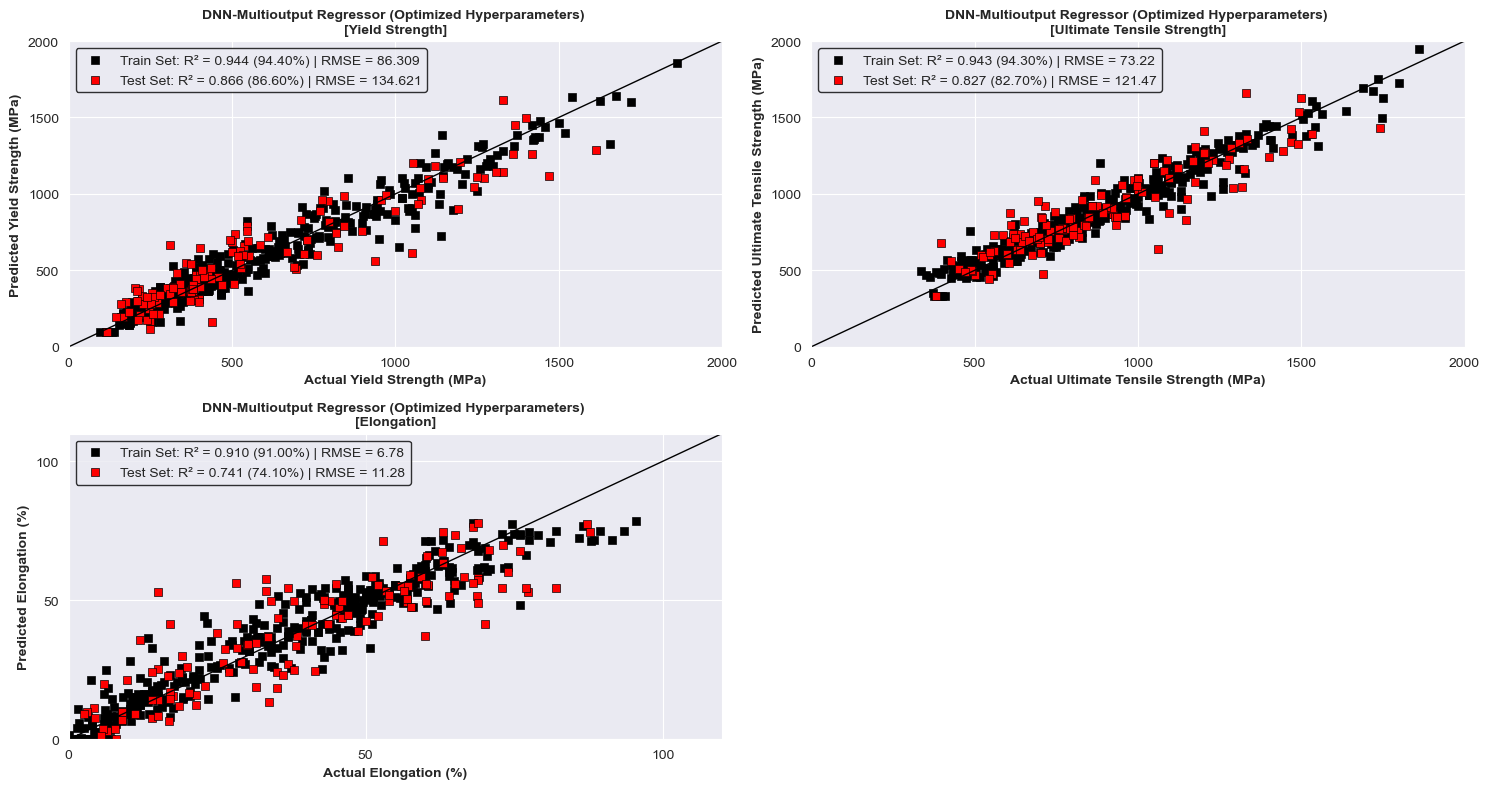

In [367]:
plt.figure(figsize = (15, 8))
sns.set_style("darkgrid")

# plot for YS 
plt.subplot(2, 2, 1)
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Predicted YS (MPa)", 
                data = dnn_gs_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_gs_ed_train_r2_ys, dnn_gs_ed_train_r2_ys*100, dnn_gs_ed_train_rmse_ys))
sns.scatterplot(x = "Actual YS (MPa)", 
                y = "Predicted YS (MPa)", 
                data = dnn_gs_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.3f}".format(dnn_gs_ed_test_r2_ys, dnn_gs_ed_test_r2_ys*100, dnn_gs_ed_test_rmse_ys))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Optimized Hyperparameters) \n[Yield Strength]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Yield Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

# plot for UTS
plt.subplot(2, 2, 2)
sns.scatterplot(x = "Actual UTS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_gs_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.2f}".format(dnn_gs_ed_train_r2_uts, dnn_gs_ed_train_r2_uts*100, dnn_gs_ed_train_rmse_uts))
sns.scatterplot(x = "Actual UTS (MPa)", 
                y = "Predicted UTS (MPa)", 
                data = dnn_gs_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.2f}".format(dnn_gs_ed_test_r2_uts, dnn_gs_ed_test_r2_uts*100, dnn_gs_ed_test_rmse_uts))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 2000], y = [0, 2000], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Optimized Hyperparameters) \n[Ultimate Tensile Strength]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Ultimate Tensile Strength (MPa)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 2000)
plt.ylim(0, 2000)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 2001, 500))
plt.yticks(np.arange(0, 2001, 500))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

# plot for EL
plt.subplot(2, 2, 3)
sns.scatterplot(x = "Actual EL (%)", 
                y = "Predicted EL (%)", 
                data = dnn_gs_ed_train_df,
                marker = "s",
                color = "black",
                edgecolor = "black", 
                label = "Train Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.2f}".format(dnn_gs_ed_train_r2_el, dnn_gs_ed_train_r2_el*100, dnn_gs_ed_train_rmse_el))
sns.scatterplot(x = "Actual EL (%)", 
                y = "Predicted EL (%)", 
                data = dnn_gs_ed_test_df,
                marker = "s",
                color = "red",
                edgecolor = "black", 
                label = "Test Set: R² = {:.3f} ({:.2f}%) | RMSE = {:.2f}".format(dnn_gs_ed_test_r2_el, dnn_gs_ed_test_r2_el*100, dnn_gs_ed_test_rmse_el))
# diagonal line representing perfect prediction 
sns.lineplot(x = [0, 110], y = [0, 110], color = "black", linewidth = 1)
plt.title("DNN-Multioutput Regressor (Optimized Hyperparameters) \n[Elongation]", fontsize = 10, fontweight = "bold")
plt.xlabel("Actual Elongation (%)", fontsize = 10, fontweight = "bold")
plt.ylabel("Predicted Elongation (%)", fontsize = 10, fontweight = "bold")
# set x and y axis limits
plt.xlim(0, 110)
plt.ylim(0, 110)
# set ticks for x and y axes 
plt.xticks(np.arange(0, 110, 50))
plt.yticks(np.arange(0, 110, 50))
plt.legend(frameon = True, fontsize = 10, edgecolor = "black")

plt.tight_layout()
plt.show()

### **(D) Save the model**

In [ ]:
# access the underlying keras model
dnn_mo_model = dnn_gs_ed.model_

# save the keras model
dnn_mo_model.save("dnn_mo_gs_ed.h5")

In [ ]:
from tensorflow.keras.models import load_model
# load the model from h5 file 
dnn_mo_gs_model = load_model('dnn_mo_gs_ed.h5', custom_objects = {'custom_mse_loss': custom_mse_loss})